<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantumsensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Enhanced Photon Localization in Quantum Sensing**

Central [document](https://docs.google.com/document/d/1ucfrL5oZv-1sTyBCa1ogVRw6TWCYHJEIOzk1IHKTOGM/edit?tab=t.0#heading=h.72b3jgubjxky) with notes

@jmcclean
@deltorobarba

**Research status on quantum advantage in photon localization to include in our experiment**
* Large error bars in low photon count analysis suggest to run more statistical trials to get clearer statistical significance.
* Test with different projection techniques to see if we can further increase the advantage as done with the unitary projection approach
1. Low photon number regimes (extremely low light levels) since classical methods struggle due to shot noise https://www.mdpi.com/2412-382X/8/3/19
2. Non-classical sources (entangled photons, squeezed light, and single-photon emitters) for localization? Performs well for larger resolution, higher sensitivity, and noise reduction in imaging and sensing https://arxiv.org/html/2411.08415v1
3. Apply adaptive phase strategies, compare standard phase measurements to optimal quantum measurements, and the evaluate performance near the Heisenberg limit https://opg.optica.org/oe/fulltext.cfm?uri=oe-30-24-43143&id=51894
4. Quantum super-resolution imaging by Photon Statistics (QSIPS) show superior performance to classical methods like SOFI, especially in low-light conditions and with non-Poissonian emitters (!) - also for localization? https://arxiv.org/abs/2408.11654
5. How can different physically realistic noise types influence photon detection and propagation, e.g. photon loss (amplitude damping channel), dephasing noise (phase damping channel), thermal noise (thermal state mixing) vs generic noise model (α·I/d), here: (Certain) Noise Can Boost Quantum Entanglement: https://thequantuminsider.com/2025/01/23/noise-annoys-no-longer-study-finds-certain-noise-can-boost-quantum-entanglement/
6. Estimate multiple parameters simultaneously (intensity + polarization) for information gain https://journals.aps.org/prx/abstract/10.1103/PhysRevX.12.011039
7. Compare our empirical results with theoretical Cramér-Rao bound and quantum fische information for classical and for quantum estimation to see how close our approach gets to the fundamental limits on the precision of parameter estimation. https://www.tandfonline.com/doi/abs/10.1080/00107510601009871 and https://pmc.ncbi.nlm.nih.gov/articles/PMC9950091/#:~:text=Generally%2C%20the%20ultimate%20precision%20of,14%2C%20which%20can%20be%20explicitly

##### <font color="blue">*Libraries*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
import time
import warnings
warnings.filterwarnings('ignore')

##### <font color="blue">*System Setup and Hyperparameters*

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Setup parameters
L = 1.0        # Length of the sensor array
d = 20         # Number of sensors
delta = L / d  # Sensor spacing
k = 5          # Wave number parameter
l = 0.3        # Cutoff length (exponential decay range)
alpha = 0.3    # Default noise level

# Number of samples to generate for main experiment to get accurate results
num_samples = 50

# Number of measurements for each density matrix in data generation with empirical density matrices
n_measurements = 100
n_pred_samples = 20

# Photon count analysis
photon_counts=[0.1, 0.2, 0.5, 0.7, 1, 5, 10, 15, 20, 25, 50, 100, 200]
  # average photon count: 5   = Probability of detecting zero photons in any measurement is ~0.7%
  # average photon count: 0.5 = Probability of detecting zero photons in any measurement is ~60.7%
  # average photon count: 0.1 = Probability of detecting zero photons in any measurement is ~90%
avg_photons = 1 # redundant now, i need to remove this


# Number of samples to generate for analyses functions to observe trends and reduce computational cost
num_samples_analyze_noise_impact = 10
num_samples_analyze_copies_impact = 10

# Number of runs of basic experiment
n_basic_runs = 10
n_noise_runs = 5
n_copies_runs = 5

# Number of copies for copies impact analysis (Full range of copy numbers)
n_copies_list = [1, 2, 4, 8]  # Extended analysis
max_extrapolation = 16        # For extrapolation to higher copy numbers
n_runs = 3        # Number of statistical runs

# Sensor positions for all sensors
sensor_positions = np.linspace(0, L, d, endpoint=False)

##### <font color="blue">*Quantum State Representation including Phase Encoding*

In [ ]:
# Create quantum pure state for source at position s
def create_pure_state(s):
    # Phase encoding based on distance between source and sensors
      # Phase is proportional to physical distance
      # Wave number k determines spatial frequency
      # Phase pattern localizes around source position
    phases = -2 * np.pi * k * (s - sensor_positions)

    # Apply cutoff effect where signal decays with distance
    cutoff_factor = np.exp(-np.abs(s - sensor_positions) / l)

    # Normalize and create state vector with proper phases
    amplitudes = cutoff_factor / np.sqrt(np.sum(cutoff_factor**2))
    state = amplitudes * np.exp(1j * phases)

    # Complex state vector representing quantum state
    return state

Photon from source position s interacts with sensor array, quantum state is:

> $|\psi(s)\rangle = \sum_{j=0}^{d-1} \phi_j(s) |j\rangle$

with $|j\rangle$ being basis state to $j$-th sensor detecting the photon, and $\phi_j(s)$ the probability amplitude for detection at sensor $j$.

Quantum state $|\psi(s)\rangle$ is built from phases calculated for each sensor based on the source position, cutoff distance applied, amplitudes normalized (to get a valid quantum state), combine amplitudes and phases for the final compex-valued state vector. Each array element corresponds to $\psi_j(s)$ for sensor j.

*Nota bene: the phase encoding part relates the source position s to the phase of the quantum state at each sensor position:*

> $\phi_j(s) = \frac{1}{\sqrt{d}} \exp\left(-i \frac{2\pi k}{d}(s - j\delta)\right)$

k is wave number, $(s - j\delta)$ is distance between source and sensor $j$ computed by `(s - sensor_positions)`:

```
phases = -2 * np.pi * k * (s - sensor_positions) / d
```



##### <font color="blue">*Density Matrix Formation (Noise Model) and theoretical limit*

In [ ]:
# Create density matrix with noise level alpha
def create_density_matrix(state, alpha):
    # Pure state density matrix
    rho_pure = np.outer(state, np.conjugate(state))

    # Add noise (mixing with maximally mixed state)
    rho = (1 - alpha) * rho_pure + alpha * np.eye(d) / d

    return rho

In [ ]:
# Create empirical density matrix from finite number of measurements
def create_empirical_density_matrix(state, alpha, n_samples):
    d = len(state)

    # Theoretical density matrix for reference
    rho_pure = np.outer(state, np.conjugate(state))
    rho_mixed = np.eye(d) / d
    rho_theoretical = (1 - alpha) * rho_pure + alpha * rho_mixed

    # Samples for each measurement in multiple bases for tomography
    # This is a simplified approach with three bases per qubit
    empirical_counts = np.zeros((d, d), dtype=complex)

    # Generate measurements in different bases
    for _ in range(n_samples):
        # Randomly select if sampled from pure or mixed component
        if np.random.rand() < alpha:
            # Sample from maximally mixed state
            outcome = np.random.randint(0, d)
            basis_state = np.zeros(d, dtype=complex)
            basis_state[outcome] = 1.0
            proj = np.outer(basis_state, np.conjugate(basis_state))
        else:
            # Sample from pure state accord to Born rule
            probabilities = np.abs(state)**2
            outcome = np.random.choice(d, p=probabilities)
            basis_state = np.zeros(d, dtype=complex)
            basis_state[outcome] = 1.0
            proj = np.outer(basis_state, np.conjugate(basis_state))

        # Add to counts (simplified tomography)
        empirical_counts += proj

    # Normalize to get empirical density matrix
    rho_empirical = empirical_counts / n_samples

    # Ensure the matrix is Hermitian (physical)
    rho_empirical = (rho_empirical + np.conjugate(rho_empirical.T)) / 2

    # Ensure trace 1 (physical)
    trace = np.trace(rho_empirical)
    if trace > 0:
        rho_empirical = rho_empirical / trace

    return rho_empirical

In [ ]:
# Create empirical density matrix with shot noise for low photon numbers
def create_empirical_density_matrix_low_photon(state, alpha, n_samples, avg_photons=avg_photons):
    d = len(state)

    # Theoretical density matrix for reference
    rho_pure = np.outer(state, np.conjugate(state))
    rho_mixed = np.eye(d) / d

    # Samples for each measurement in multiple bases for tomography
    empirical_counts = np.zeros((d, d), dtype=complex)

    # Generate measurements in different bases
    actual_measurements = 0
    for _ in range(n_samples):
        # First determine if any photons are detected in this measurement
        # Poisson distribution for photon arrivals
        photon_count = np.random.poisson(avg_photons)

        if photon_count == 0:
            # No photons detected, no information gained
            continue

        actual_measurements += 1

        # For measurements with photons, proceed with added shot noise
        if np.random.rand() < alpha:
            # Sample from maximally mixed state
            outcome = np.random.randint(0, d)
            basis_state = np.zeros(d, dtype=complex)
            basis_state[outcome] = 1.0
            proj = np.outer(basis_state, np.conjugate(basis_state))
        else:
            # Sample from pure state according to Born rule
            # but with shot noise proportional to 1/sqrt(photon_count)
            probabilities = np.abs(state)**2

            # Add shot noise to probabilities
            noise_level = 1.0 / np.sqrt(max(1, photon_count))
            probabilities_noisy = probabilities + noise_level * np.random.randn(len(probabilities))
            probabilities_noisy = np.abs(probabilities_noisy)  # Ensure non-negative
            probabilities_noisy = probabilities_noisy / np.sum(probabilities_noisy)  # Normalize

            outcome = np.random.choice(d, p=probabilities_noisy)
            basis_state = np.zeros(d, dtype=complex)
            basis_state[outcome] = 1.0
            proj = np.outer(basis_state, np.conjugate(basis_state))

        # Add to counts
        empirical_counts += proj

    # If no actual measurements were performed, return a maximally mixed state
    if actual_measurements == 0:
        return np.eye(d) / d

    # Normalize to get empirical density matrix
    rho_empirical = empirical_counts / max(1, actual_measurements)

    # Ensure the matrix is Hermitian (physical)
    rho_empirical = (rho_empirical + np.conjugate(rho_empirical.T)) / 2

    # Ensure trace 1 (physical)
    trace = np.trace(rho_empirical)
    if trace > 0:
        rho_empirical = rho_empirical / trace

    return rho_empirical

**Density Matrix Formation**

Pure state density matrix is:

> $\rho_{pure} = |\psi(s)\rangle\langle\psi(s)|$

implemented as `rho_pure = np.outer(state, np.conjugate(state))`

Noisy density matrix with noise parameter $\alpha \in [0,1]$ is:

> $\rho = (1-\alpha)|\psi(s)\rangle\langle\psi(s)| + \alpha\frac{I}{d}$

- $(1-\alpha)$ is the fraction of the pure state preserved
- $\alpha\frac{I}{d}$ is uniform mixing (here white noise)
- $I$ is identity

Noise model is implemented by mixing with maximally mixed state: $\frac{I}{d}$ as `rho = (1 - alpha) * rho_pure + alpha * np.eye(d) / d`, using a **depolarizing noise model**, where with probability $\alpha$, the pure state is replaced by a completely mixed state $\frac{I}{d}$.

##### <font color="blue">*Information Extraction (Vectorization)*

In [ ]:
def vectorize_density_matrix(rho):
    # Convert density matrix to feature vector for ML. Extract real and imaginary parts and concatenate
    vec_real = np.real(rho).flatten()
    vec_imag = np.imag(rho).flatten()
    return np.concatenate((vec_real, vec_imag))

def get_classical_info(rho):
    # Extract classical information (diagonal elements)
    return np.real(np.diag(rho))

Quantum information is extracted with `vectorize_density_matrix`, including phase relationships from off-diagonal elements. Classical information (detection probabilities) is in diagonal elements of the density matrix $\rho_jj = (1- \alpha)|\phi_j(s)|^2 + \alpha(\frac{1}{d}) $ and is extracted from diagonal elements with `get_classical_info`.

***Appendix: Phase Differences and Localization***

The phase difference between two sensors next to each other $j$ and $j+1$ is

> $\Delta \phi_{j,j+1}(s) = \arg(\phi_{j+1}(s)) - \arg(\phi_j(s)) = \frac{2\pi k\delta}{d}$

This constant phase difference encodes information about the source location. For any two sensors $j$ and $m$

> $\Delta \phi_{j,m}(s) = \frac{2\pi k\delta}{d}(m-j)$

the total phase accumulated across the array follows a linear relationship with the source position. This allows the localization.

- The quantum state `state = amplitudes * np.exp(1j * phases)` contains the phase information (each element has a phase that depends on the source position)
   ```python
   phases = -2 * np.pi * k * (s - sensor_positions) / d
   state = amplitudes * np.exp(1j * phases)
   ```
- The density matrix `rho` preserves this phase information in its off-diagonal elements. The vectorized density matrix retains phase relationships.
- The ML models can discover the patterns during training (which aspects of phase information are most useful for localization?), which quantifies quantum advantage.

##### <font color="blue">*Multiple Copies Function*

In [ ]:
def create_copies(X, n_copies):
    if n_copies == 1:
        return X

    # Tensor product implementation for all copy numbers
    result = []
    for x in X:
        # Reshape to get back density matrix form
        d = int(np.sqrt(len(x) / 2))  # Dimension of density matrix
        real_part = x[:len(x)//2].reshape(d, d)
        imag_part = x[len(x)//2:].reshape(d, d)
        rho = real_part + 1j * imag_part

        # Create tensor product
        rho_tensor = rho.copy()
        for _ in range(n_copies - 1):
            rho_tensor = np.kron(rho_tensor, rho)

        # Vectorize result
        vec_real = np.real(rho_tensor).flatten()
        vec_imag = np.imag(rho_tensor).flatten()
        result.append(np.concatenate((vec_real, vec_imag)))

    return np.array(result)

***Achtung: Computational complexity, for example, with 20 sensors using tensor product:***
* 1 copy: 20x20 density matrix (400 elements)
* 2 copies: 400x400 density matrix (160,000 elements)
* 4 copies: 160,000x160,000 density matrix (25.6 billion elements)

*Expected memory requirements for the updated run_copies_analysis function:*
* 1 copies: approx. 800 features, 0.01 MB per sample
* 2 copies: approx. 160000 features, 1.22 MB per sample
* 4 copies: approx. 25600000000 features, 191.31 GB per sample
* 8 copies: approx. 6.55e+19 features, 4.99e+14 GB per sample

##### <font color="blue">*Classical limits for noise model*

The fundamental limit to how much information we can extract from a single measurement of quantum state $\rho$ that represents a source at position $s$ (related to quantum Cramér-Rao bound for parameter estimation). For $n$ identical copies of $\rho$, the joint state is the tensor product

> $\rho^{\otimes n} = \underbrace{\rho \otimes \rho \otimes ... \otimes \rho}_{n \text{ times}}$

with the Fisher information we can determine how precisely we can estimate $s$, which scales linearly with the number of copies

> $F_n(s) = n \cdot F_1(s)$

The precision limit improves by a factor of $\sqrt{n}$

> $\Delta s_{min} \propto \frac{1}{\sqrt{F_n(s)}} = \frac{1}{\sqrt{n \cdot F_1(s)}} = \frac{1}{\sqrt{n}} \cdot \frac{1}{\sqrt{F_1(s)}}$





***Classical limits for noise model***

The statistical variance in phase estimation at sensor $j$ due to noise can be as follows. It shows that phase uncertainty increases with noise level $\alpha$ and decreases with signal strength at that sensor:

> $\text{Var}[\arg(\rho_{jj})] \approx \frac{\alpha}{2(1-\alpha)|\phi_j(s)|^2}$

For sensors beyond the cutoff length $l$ from source, the signal-to-noise ratio decreases exponentially and limits information to sensors within range $l$ of source s:

> $\text{SNR}_j \propto \exp\left(-\frac{|s - j\delta|}{l}\right)$

The classical information is in the diagonal elements of the density matrix (probability of detecting the photon at sensor $j$)

> $\rho_{jj} = (1-\alpha)|\phi_j(s)|^2 + \alpha\frac{1}{d}$

The theoretical minimum variance for an unbiased estimator of source position $s$ using only classical information is (cramér-rao bound for classical localization)

> $\text{Var}(s_{est}) \geq \frac{1}{F_C(s)}$

$F_C(s)$ is fisher information:

> $F_C(s) = \sum_{j=0}^{d-1} \frac{1}{\rho_{jj}} \left(\frac{\partial \rho_{jj}}{\partial s}\right)^2$

Potential quantum advantage comes from ratio of quantum Fisher information to classical Fisher information ($F_Q(s)$ includes phase information in the off-diagonal elements of $\rho$):

> $\eta = \frac{F_Q(s)}{F_C(s)}$

With cutoff length $l$ and noise level $\alpha$ the classical localization precision limit can be approximately at

> $\Delta s_{min} \approx \frac{l}{\sqrt{N_{eff}}}$

$N_{eff} \approx \frac{l}{\delta}(1-\alpha)$ is the number of sensors that contribute meaningful information.

##### <font color="blue">*Data Generation*

In [ ]:
# Generate dataset using empirical density matrices with low photon counts
def generate_dataset_low_photon(num_samples, alpha, quantum=True, n_copies=1, n_measurements=n_measurements, avg_photons=avg_photons):
    X, y = [], []

    for _ in range(num_samples):
        # Random source location
        s = np.random.rand() * L

        # Create quantum state
        state = create_pure_state(s)

        # Create empirical density matrix with low photon counts
        rho = create_empirical_density_matrix_low_photon(state, alpha, n_measurements, avg_photons)

        # Extract features
        if quantum:
            features = vectorize_density_matrix(rho)
        else:
            features = get_classical_info(rho)

        # Create copies if needed
        if n_copies > 1:
            # Each copy gets its own independent measurements
            features_copies = []
            for _ in range(n_copies):
                # Create a new empirical density matrix for each copy
                rho_copy = create_empirical_density_matrix_low_photon(state, alpha, n_measurements, avg_photons)

                if quantum:
                    features_copy = vectorize_density_matrix(rho_copy)
                else:
                    features_copy = get_classical_info(rho_copy)

                features_copies.append(features_copy)

            # Tensor product of all copies
            features = create_copies(np.array(features_copies), 1)[0]

        X.append(features)
        y.append(s)

    return np.array(X), np.array(y)

In [ ]:
# Generate dataset of source positions and corresponding quantum states
def generate_dataset(num_samples, alpha, quantum=True, n_copies=1):
    X, y = [], []

    for _ in range(num_samples):
        # Random source location
        s = np.random.rand() * L

        # Create quantum state and density matrix
        state = create_pure_state(s)
        rho = create_density_matrix(state, alpha)

        # Extract features
        if quantum:
            features = vectorize_density_matrix(rho)
        else:
            features = get_classical_info(rho)

        # Create copies if needed
        if n_copies > 1:
            features = create_copies(np.array([features]), n_copies)[0]

        X.append(features)
        y.append(s)

    return np.array(X), np.array(y)

* first generate random source positions s ∈ [0, L]
* then creates corresponding quantum states |ψ(s)⟩
* adds noise to create density matrices $\rho$
* extracts full quantum or classical information
* and creates multiple copies (related to Fisher information scaling)

In [ ]:
# Generate dataset using empirical density matrices from finite measurements
def generate_dataset_with_sampling(num_samples, alpha, quantum=True, n_copies=1, n_measurements=n_measurements):
    X, y = [], []

    for _ in range(num_samples):
        # Random source location
        s = np.random.rand() * L

        # Create quantum state
        state = create_pure_state(s)

        # Create empirical density matrix from finite measurements
        rho = create_empirical_density_matrix(state, alpha, n_measurements)

        # Extract features
        if quantum:
            features = vectorize_density_matrix(rho)
        else:
            features = get_classical_info(rho)

        # Create copies if needed
        if n_copies > 1:
            # Each copy gets its own independent measurements
            features_copies = []
            for _ in range(n_copies):
                # Create a new empirical density matrix for each copy
                rho_copy = create_empirical_density_matrix(state, alpha, n_measurements)

                if quantum:
                    features_copy = vectorize_density_matrix(rho_copy)
                else:
                    features_copy = get_classical_info(rho_copy)

                features_copies.append(features_copy)

            # Tensor product of all copies
            features = create_copies(np.array(features_copies), 1)[0]

        X.append(features)
        y.append(s)

    return np.array(X), np.array(y)

##### <font color="blue">*Calculate statistics*

In [ ]:
# Calculate mean, standard deviation and confidence intervals for a list of values
def calculate_stats(values, confidence=0.95):
    mean = np.mean(values)
    std_dev = np.std(values, ddof=1)  # Sample standard deviation

    # Calculate confidence interval
    n = len(values)
    sem = std_dev / np.sqrt(n)  # Standard error of mean
    h = sem * stats.t.ppf((1 + confidence) / 2, n - 1)  # Margin of error

    return mean, std_dev, h

In [ ]:
# Perform t-tests to compare different models and return p-values
def perform_t_tests(results_dict):
    p_values = {}

    # Compare quantum linear vs. quantum quadratic
    p_values['q_linear_vs_q_quad'] = stats.ttest_ind(
        results_dict['rmse_linear_q_all'],
        results_dict['rmse_quad_q_all']
    ).pvalue

    # Compare classical linear vs. classical quadratic
    p_values['c_linear_vs_c_quad'] = stats.ttest_ind(
        results_dict['rmse_linear_c_all'],
        results_dict['rmse_quad_c_all']
    ).pvalue

    # Compare quantum linear vs. classical linear
    p_values['q_linear_vs_c_linear'] = stats.ttest_ind(
        results_dict['rmse_linear_q_all'],
        results_dict['rmse_linear_c_all']
    ).pvalue

    # Compare quantum quadratic vs. classical quadratic
    p_values['q_quad_vs_c_quad'] = stats.ttest_ind(
        results_dict['rmse_quad_q_all'],
        results_dict['rmse_quad_c_all']
    ).pvalue

    return p_values

##### <font color="blue">*Machine Learning Model*

In [ ]:
# ML Model with degrees for basis experiment and noise impact (polynomial degree 1=linear, 2=quadratic)
def train_and_evaluate_with_degree(X_train, X_test, y_train, y_test, degree=1):
    if degree == 1:
        model = LinearRegression()
    else:
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree)),
            ('linear', LinearRegression())
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse, model

In [ ]:
# Predictions with sampling to account for measurement uncertainty
  # model: trained regression model
  # X: input features
  # n_samples: number of samples for prediction
  # Returns averaged predictions

def predict_with_sampling(model, X, n_samples):
    predictions = []

    for _ in range(n_samples):
        # For linear models add noise to coefficients
        if hasattr(model, 'coef_'):
            # Clone model parameters
            coef = model.coef_.copy()
            intercept = model.intercept_.copy() if hasattr(model, 'intercept_') else 0

            # Add Gaussian noise to coefficients
            noise_level = 0.01  # 1% noise
            noisy_coef = coef * (1 + noise_level * np.random.randn(*coef.shape))
            noisy_intercept = intercept * (1 + noise_level * np.random.randn())

            # Make prediction with noisy parameters
            pred = X @ noisy_coef + noisy_intercept
        else:
            # For non-linear models, add noise to predictions directly
            pred = model.predict(X)
            noise = 0.01 * np.std(pred) * np.random.randn(len(pred))
            pred = pred + noise

        predictions.append(pred)

    # Average predictions
    return np.mean(predictions, axis=0)

In [ ]:
# Project linear model coefficients to closest unitary operation
  # model: trained LinearRegression model
  # Returns LinearRegression: new model with coefficients projected to unitary space

def project_to_unitary(model):
    # Get model coefficients
    coef = model.coef_.copy()

    # For the feature space the coefficients do not directly map to a unitary matrix
    # This implements a simplified approach that preserves quantum mechanical constraints

    # Calculate feature dimension to check if we can reshape to square matrix
    input_dim = len(coef)
    d = int(np.sqrt(input_dim/2))  # Divide by 2 due to real and imaginary parts

    if d*d*2 == input_dim:
        # Reshape to a d x d complex matrix
        real_part = coef[:d*d].reshape(d, d)
        imag_part = coef[d*d:].reshape(d, d)
        matrix = real_part + 1j * imag_part

        # Perform SVD
        U, s, Vh = np.linalg.svd(matrix, full_matrices=True)

        # Create unitary approximation
        unitary_matrix = U @ Vh

        # Convert back to coefficient format
        unitary_coef = np.concatenate([
            np.real(unitary_matrix).flatten(),
            np.imag(unitary_matrix).flatten()
        ])

        # Create new model with unitary coefficients
        unitary_model = LinearRegression()
        unitary_model.coef_ = unitary_coef
        unitary_model.intercept_ = model.intercept_

        return unitary_model
    else:
        # If reshaping to a square matrix is not possible, normalize the coefficients
        norm = np.linalg.norm(coef)
        normalized_model = LinearRegression()
        normalized_model.coef_ = coef / norm
        normalized_model.intercept_ = model.intercept_

        return normalized_model

##### <font color="blue">*Visualizations*

In [ ]:
# Visualize the quantum state for a given source position
def plot_quantum_state(s, alpha=0.3):
    # Create the quantum state
    state = create_pure_state(s)

    # Extract real and imaginary parts and amplitude
    real_part = np.real(state)
    imag_part = np.imag(state)
    amplitude = np.abs(state)**2
    phase = np.angle(state)

    # Create plots for quantum state
    plt.figure(figsize=(14, 8))

    # Plot real part
    plt.subplot(2, 2, 1)
    plt.plot(sensor_positions, real_part, 'b-o')
    plt.axvline(x=s, color='r', linestyle='--', label='Source')
    plt.title('Real Part of Quantum State')
    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot imaginary part
    plt.subplot(2, 2, 2)
    plt.plot(sensor_positions, imag_part, 'g-o')
    plt.axvline(x=s, color='r', linestyle='--', label='Source')
    plt.title('Imaginary Part of Quantum State')
    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot amplitude (probability)
    plt.subplot(2, 2, 3)
    plt.plot(sensor_positions, amplitude, 'm-o')
    plt.axvline(x=s, color='r', linestyle='--', label='Source')
    plt.title('Probability Amplitude (|ψ|²)')
    plt.xlabel('Position')
    plt.ylabel('Probability')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot phase
    plt.subplot(2, 2, 4)
    plt.plot(sensor_positions, phase, 'c-o')
    plt.axvline(x=s, color='r', linestyle='--', label='Source')
    plt.title('Phase of Quantum State')
    plt.xlabel('Position')
    plt.ylabel('Phase (radians)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print wavelength information for sanity check
    wavelength = 1 / k
    print(f"Wave number parameter k = {k}")
    print(f"Corresponding wavelength = {wavelength:.4f}")
    print(f"Array length L = {L}")
    print(f"Number of wavelengths in array = {L/wavelength:.2f}")

    # Create density matrix with noise
    rho = create_density_matrix(state, alpha)

    # Create a new figure for density matrix visualization
    plt.figure(figsize=(12, 5))

    # Plot real part of density matrix
    plt.subplot(1, 2, 1)
    plt.imshow(np.real(rho), cmap='viridis')
    plt.colorbar(label='Real Part')
    plt.title(f'Real Part of Density Matrix (α={alpha})')
    plt.xlabel('Sensor Index')
    plt.ylabel('Sensor Index')

    # Plot imaginary part of density matrix
    plt.subplot(1, 2, 2)
    plt.imshow(np.imag(rho), cmap='RdBu')
    plt.colorbar(label='Imaginary Part')
    plt.title(f'Imaginary Part of Density Matrix (α={alpha})')
    plt.xlabel('Sensor Index')
    plt.ylabel('Sensor Index')

    plt.tight_layout()
    plt.show()

* Real part shiuld show wave-like pattern with expected wavelength
* Phase changes linearly with distance from source
* Amplitude is localized around the source position

In [ ]:
# Run with different source positions for sanity check
def run_state_visualization():
    print("Visualizing quantum states with corrected phase encoding")

    # Test with source at different positions
    plot_quantum_state(0.25)
    plot_quantum_state(0.5)
    plot_quantum_state(0.75)

    print("Visualization complete")

##### <font color="blue">*Simulation 0: Low Photon Count*

In [ ]:
# Analyze impact of low photon numbers on model performance

def run_low_photon_analysis(n_runs=n_runs, photon_counts=photon_counts):
    all_results = []

    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        np.random.seed(42 + run)

        run_results = {
            'photon_counts': photon_counts,
            'quantum_linear': [],
            'quantum_linear_unitary': [],
            'classical_linear': [],
        }

        for avg_photons in photon_counts:
            print(f"  Testing with {avg_photons} average photons")

            # Generate quantum data with finite sampling
            X_quantum, y_quantum = generate_dataset_low_photon(
                num_samples, alpha, quantum=True,
                n_measurements=n_measurements, avg_photons=avg_photons)
            X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_quantum, y_quantum, test_size=0.2)

            # Generate classical data with finite sampling
            X_classical, y_classical = generate_dataset_low_photon(
                num_samples, alpha, quantum=False,
                n_measurements=n_measurements, avg_photons=avg_photons)
            X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_classical, y_classical, test_size=0.2)

            # Train and evaluate models - USE THE RENAMED FUNCTION
            rmse_linear_q, linear_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=1)
            rmse_linear_c, linear_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=1)

            # Project linear quantum model to unitary space
            unitary_model_q = project_to_unitary(linear_model_q)
            y_pred_unitary = unitary_model_q.predict(X_test_q)
            rmse_lin_q_unitary = np.sqrt(mean_squared_error(y_test_q, y_pred_unitary))

            # Store results
            run_results['quantum_linear'].append(rmse_linear_q)
            run_results['quantum_linear_unitary'].append(rmse_lin_q_unitary)
            run_results['classical_linear'].append(rmse_linear_c)

        all_results.append(run_results)

    # Process results
    combined_results = {
        'photon_counts': photon_counts,
    }

    # Calculate statistics for each photon count
    for model_type in ['quantum_linear', 'quantum_linear_unitary', 'classical_linear']:
        combined_results[f'{model_type}_mean'] = []
        combined_results[f'{model_type}_std'] = []
        combined_results[f'{model_type}_ci'] = []

        for photon_idx in range(len(photon_counts)):
            values = [run_result[model_type][photon_idx] for run_result in all_results]
            mean, std_dev, ci = calculate_stats(values)

            combined_results[f'{model_type}_mean'].append(mean)
            combined_results[f'{model_type}_std'].append(std_dev)
            combined_results[f'{model_type}_ci'].append(ci)

    # Calculate quantum advantage metrics
    combined_results['quantum_advantage'] = []
    combined_results['quantum_advantage_ci'] = []

    for i in range(len(photon_counts)):
        # Calculate relative advantage (1 - quantum/classical)
        q_mean = combined_results['quantum_linear_mean'][i]
        c_mean = combined_results['classical_linear_mean'][i]

        # Relative improvement
        if c_mean > 0:
            advantage = (c_mean - q_mean) / c_mean  # Positive means quantum is better
        else:
            advantage = 0

        # Error propagation for advantage
        q_ci = combined_results['quantum_linear_ci'][i]
        c_ci = combined_results['classical_linear_ci'][i]

        # Simplified error propagation
        advantage_ci = np.sqrt((q_ci/c_mean)**2 + (c_ci*q_mean/c_mean**2)**2) if c_mean > 0 else 0

        combined_results['quantum_advantage'].append(advantage)
        combined_results['quantum_advantage_ci'].append(advantage_ci)

    # Plot results
    plt.figure(figsize=(12, 10))

    # Plot 1: RMSE vs Photon Counts
    plt.subplot(2, 1, 1)
    plt.errorbar(photon_counts, combined_results['quantum_linear_mean'],
                 yerr=combined_results['quantum_linear_ci'],
                 fmt='o-', capsize=5, label='Quantum Linear')

    plt.errorbar(photon_counts, combined_results['quantum_linear_unitary_mean'],
                 yerr=combined_results['quantum_linear_unitary_ci'],
                 fmt='x-', capsize=5, label='Quantum Linear Unitary')

    plt.errorbar(photon_counts, combined_results['classical_linear_mean'],
                 yerr=combined_results['classical_linear_ci'],
                 fmt='s--', capsize=5, label='Classical Linear')

    plt.xscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('RMSE')
    plt.title('Model Performance vs. Average Photon Count')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 2: Quantum Advantage vs Photon Counts
    plt.subplot(2, 1, 2)
    plt.errorbar(photon_counts, combined_results['quantum_advantage'],
                 yerr=combined_results['quantum_advantage_ci'],
                 fmt='o-', capsize=5, color='purple')

    plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.xlabel('Average Photon Count')
    plt.ylabel('Quantum Advantage\n(relative improvement)')
    plt.title('Quantum Advantage vs. Average Photon Count')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nSummary of Low Photon Number Analysis:")
    print("\nRMSE for different photon counts (with 95% CI):")

    for i, photons in enumerate(photon_counts):
        print(f"\nAverage photon count: {photons}")
        print(f"  - Quantum Linear RMSE: {combined_results['quantum_linear_mean'][i]:.6f} ± {combined_results['quantum_linear_ci'][i]:.6f}")
        print(f"  - Quantum Linear Unitary RMSE: {combined_results['quantum_linear_unitary_mean'][i]:.6f} ± {combined_results['quantum_linear_unitary_ci'][i]:.6f}")
        print(f"  - Classical Linear RMSE: {combined_results['classical_linear_mean'][i]:.6f} ± {combined_results['classical_linear_ci'][i]:.6f}")
        print(f"  - Quantum Advantage: {combined_results['quantum_advantage'][i]*100:.2f}% ± {combined_results['quantum_advantage_ci'][i]*100:.2f}%")

    return combined_results

##### <font color="blue">*Simulation 1: Basic Experiment*

In [ ]:
# Run the basic experiment
def run_basic_experiment(n_runs=n_basic_runs, perform_tests=True):
    print("Running basic experiment comparing linear and quadratic models")

    # Lists to store RMSE values from multiple runs
    rmse_linear_q_all = []
    rmse_quad_q_all = []
    rmse_linear_c_all = []
    rmse_quad_c_all = []

    # Store models from the last run for visualization
    final_models = {}
    final_data = {}

    for run in range(n_runs):
        # Set a different random seed for each run
        np.random.seed(42 + run)

        # Generate quantum data
        X_quantum, y_quantum = generate_dataset(num_samples, alpha, quantum=True)
        X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_quantum, y_quantum, test_size=0.2)

        # Generate classical data (diagonal only)
        X_classical, y_classical = generate_dataset(num_samples, alpha, quantum=False)
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_classical, y_classical, test_size=0.2)

        # Train and evaluate models
        rmse_linear_q, linear_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=1)
        rmse_quad_q, quad_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=2)

        rmse_linear_c, linear_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=1)
        rmse_quad_c, quad_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=2)

        # Store results
        rmse_linear_q_all.append(rmse_linear_q)
        rmse_quad_q_all.append(rmse_quad_q)
        rmse_linear_c_all.append(rmse_linear_c)
        rmse_quad_c_all.append(rmse_quad_c)

        # Store models and data from the last run for visualization
        if run == n_runs - 1:
            final_models = {
                'linear_q': linear_model_q,
                'quad_q': quad_model_q
            }
            final_data = {
                'X_test_q': X_test_q,
                'y_test_q': y_test_q
            }

    # Calculate statistics
    mean_linear_q, std_linear_q, ci_linear_q = calculate_stats(rmse_linear_q_all)
    mean_quad_q, std_quad_q, ci_quad_q = calculate_stats(rmse_quad_q_all)
    mean_linear_c, std_linear_c, ci_linear_c = calculate_stats(rmse_linear_c_all)
    mean_quad_c, std_quad_c, ci_quad_c = calculate_stats(rmse_quad_c_all)

    # Display results with confidence intervals
    print("\nResults with 95% Confidence Intervals:")
    print(f"  - Quantum Linear Model RMSE (95% CI): {mean_linear_q:.6f} ± {ci_linear_q:.6f}")
    print(f"  - Quantum Quadratic Model RMSE (95% CI): {mean_quad_q:.6f} ± {ci_quad_q:.6f}")
    print(f"  - Classical Linear Model RMSE (95% CI): {mean_linear_c:.6f} ± {ci_linear_c:.6f}")
    print(f"  - Classical Quadratic Model RMSE (95% CI): {mean_quad_c:.6f} ± {ci_quad_c:.6f}")

    # Perform statistical tests if requested
    if perform_tests:
        results_dict = {
            'rmse_linear_q_all': rmse_linear_q_all,
            'rmse_quad_q_all': rmse_quad_q_all,
            'rmse_linear_c_all': rmse_linear_c_all,
            'rmse_quad_c_all': rmse_quad_c_all
        }
        p_values = perform_t_tests(results_dict)

        print("\nStatistical Tests (p-values):")
        print(f"  - Quantum Linear vs. Quantum Quadratic: {p_values['q_linear_vs_q_quad']:.6f}")
        print(f"  - Classical Linear vs. Classical Quadratic: {p_values['c_linear_vs_c_quad']:.6f}")
        print(f"  - Quantum Linear vs. Classical Linear: {p_values['q_linear_vs_c_linear']:.6f}")
        print(f"  - Quantum Quadratic vs. Classical Quadratic: {p_values['q_quad_vs_c_quad']:.6f}")

        # Interpret significance
        alpha_level = 0.05
        print("\nStatistical Significance (α = 0.05):")
        for test, p_value in p_values.items():
            significant = "Significant" if p_value < alpha_level else "Not significant"
            print(f"  - {test}: {significant} (p = {p_value:.6f})")

    # Make predictions for visualization using models from the last run
    y_pred_linear_q = final_models['linear_q'].predict(final_data['X_test_q'])
    y_pred_quad_q = final_models['quad_q'].predict(final_data['X_test_q'])

    # Visualize results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(final_data['y_test_q'], y_pred_linear_q, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Linear Model\nRMSE: {mean_linear_q:.6f} ± {ci_linear_q:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(final_data['y_test_q'], y_pred_quad_q, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Quadratic Model\nRMSE: {mean_quad_q:.6f} ± {ci_quad_q:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return all results
    return {
        'rmse_linear_q': mean_linear_q,
        'rmse_quad_q': mean_quad_q,
        'rmse_linear_c': mean_linear_c,
        'rmse_quad_c': mean_quad_c,
        'ci_linear_q': ci_linear_q,
        'ci_quad_q': ci_quad_q,
        'ci_linear_c': ci_linear_c,
        'ci_quad_c': ci_quad_c,
        'std_linear_q': std_linear_q,
        'std_quad_q': std_quad_q,
        'std_linear_c': std_linear_c,
        'std_quad_c': std_quad_c,
        'rmse_linear_q_all': rmse_linear_q_all,
        'rmse_quad_q_all': rmse_quad_q_all,
        'rmse_linear_c_all': rmse_linear_c_all,
        'rmse_quad_c_all': rmse_quad_c_all,
        'p_values': p_values if perform_tests else None
    }

*The basic experiment runs multiple simulations (default: 10 runs) with different random seeds, collects RMSE values from each run, calculates 95% confidence intervals for each model's performance, performs t-tests to compare models, results with confidence intervals.*

##### <font color="blue">*Simulation 2: Basic Experiment (with finite sampling and unitary projection)*

In [ ]:
def run_basic_experiment_with_sampling(n_runs=n_basic_runs, perform_tests=True, n_measurements=n_measurements, n_pred_samples=n_pred_samples):

    print("Running basic experiment with finite sampling effects")

    # Lists to store RMSE values from multiple runs
    rmse_linear_q_all = []
    rmse_lin_q_unitary_all = []
    rmse_quad_q_all = []
    rmse_linear_c_all = []
    rmse_quad_c_all = []

    # Store models from the last run for visualization
    final_models = {}
    final_data = {}

    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}...")
        # Set a different random seed for each run
        np.random.seed(42 + run)

        # Generate quantum data with finite sampling
        X_quantum, y_quantum = generate_dataset_with_sampling(
            num_samples, alpha, quantum=True, n_measurements=n_measurements)
        X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_quantum, y_quantum, test_size=0.2)

        # Generate classical data with finite sampling
        X_classical, y_classical = generate_dataset_with_sampling(
            num_samples, alpha, quantum=False, n_measurements=n_measurements)
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_classical, y_classical, test_size=0.2)

        # Train and evaluate models
        rmse_linear_q, linear_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=1)
        rmse_quad_q, quad_model_q = train_and_evaluate_with_degree(X_train_q, X_test_q, y_train_q, y_test_q, degree=2)

        rmse_linear_c, linear_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=1)
        rmse_quad_c, quad_model_c = train_and_evaluate_with_degree(X_train_c, X_test_c, y_train_c, y_test_c, degree=2)

        # Project linear quantum model to unitary space
        unitary_model_q = project_to_unitary(linear_model_q)

        # Evaluate unitary-projected model
        y_pred_unitary = unitary_model_q.predict(X_test_q)
        rmse_lin_q_unitary = np.sqrt(mean_squared_error(y_test_q, y_pred_unitary))

        # Make predictions with sampling
        y_pred_linear_q_sampled = predict_with_sampling(linear_model_q, X_test_q, n_pred_samples)
        rmse_linear_q_sampled = np.sqrt(mean_squared_error(y_test_q, y_pred_linear_q_sampled))

        # Store results
        rmse_linear_q_all.append(rmse_linear_q_sampled)  # Use sampled predictions
        rmse_lin_q_unitary_all.append(rmse_lin_q_unitary)
        rmse_quad_q_all.append(rmse_quad_q)
        rmse_linear_c_all.append(rmse_linear_c)
        rmse_quad_c_all.append(rmse_quad_c)

        # Store models and data from the last run for visualization
        if run == n_runs - 1:
            final_models = {
                'linear_q': linear_model_q,
                'quad_q': quad_model_q,
                'unitary_q': unitary_model_q
            }
            final_data = {
                'X_test_q': X_test_q,
                'y_test_q': y_test_q
            }

    # Calculate statistics
    mean_linear_q, std_linear_q, ci_linear_q = calculate_stats(rmse_linear_q_all)
    mean_lin_q_unitary, std_lin_q_unitary, ci_lin_q_unitary = calculate_stats(rmse_lin_q_unitary_all)
    mean_quad_q, std_quad_q, ci_quad_q = calculate_stats(rmse_quad_q_all)
    mean_linear_c, std_linear_c, ci_linear_c = calculate_stats(rmse_linear_c_all)
    mean_quad_c, std_quad_c, ci_quad_c = calculate_stats(rmse_quad_c_all)

    # Display results with confidence intervals
    print("\nResults with 95% Confidence Intervals (with finite sampling effects):")
    print(f"  - Quantum Linear Model RMSE (95% CI): {mean_linear_q:.6f} ± {ci_linear_q:.6f}")
    print(f"  - Quantum Linear Unitary-Projected RMSE (95% CI): {mean_lin_q_unitary:.6f} ± {ci_lin_q_unitary:.6f}")
    print(f"  - Quantum Quadratic Model RMSE (95% CI): {mean_quad_q:.6f} ± {ci_quad_q:.6f}")
    print(f"  - Classical Linear Model RMSE (95% CI): {mean_linear_c:.6f} ± {ci_linear_c:.6f}")
    print(f"  - Classical Quadratic Model RMSE (95% CI): {mean_quad_c:.6f} ± {ci_quad_c:.6f}")

    # Perform statistical tests if requested
    if perform_tests:
        results_dict = {
            'rmse_linear_q_all': rmse_linear_q_all,
            'rmse_lin_q_unitary_all': rmse_lin_q_unitary_all,
            'rmse_quad_q_all': rmse_quad_q_all,
            'rmse_linear_c_all': rmse_linear_c_all,
            'rmse_quad_c_all': rmse_quad_c_all
        }

        # Extend t-tests to include unitary projection comparison
        p_values = {}

        # Original comparisons
        p_values['q_linear_vs_q_quad'] = stats.ttest_ind(
            results_dict['rmse_linear_q_all'],
            results_dict['rmse_quad_q_all']
        ).pvalue

        p_values['q_linear_vs_c_linear'] = stats.ttest_ind(
            results_dict['rmse_linear_q_all'],
            results_dict['rmse_linear_c_all']
        ).pvalue

        # New comparison for unitary projection
        p_values['q_linear_vs_q_unitary'] = stats.ttest_ind(
            results_dict['rmse_linear_q_all'],
            results_dict['rmse_lin_q_unitary_all']
        ).pvalue

        print("\nStatistical Tests (p-values):")
        print(f"  - Quantum Linear vs. Quantum Quadratic: {p_values['q_linear_vs_q_quad']:.6f}")
        print(f"  - Quantum Linear vs. Quantum Linear Unitary: {p_values['q_linear_vs_q_unitary']:.6f}")
        print(f"  - Quantum Linear vs. Classical Linear: {p_values['q_linear_vs_c_linear']:.6f}")

        # Interpret significance
        alpha_level = 0.05
        print("\nStatistical Significance (α = 0.05):")
        for test, p_value in p_values.items():
            significant = "Significant" if p_value < alpha_level else "Not significant"
            print(f"  - {test}: {significant} (p = {p_value:.6f})")

    # Make predictions for visualization using models from the last run
    y_pred_linear_q = final_models['linear_q'].predict(final_data['X_test_q'])
    y_pred_quad_q = final_models['quad_q'].predict(final_data['X_test_q'])
    y_pred_unitary = final_models['unitary_q'].predict(final_data['X_test_q'])

    # Visualize results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(final_data['y_test_q'], y_pred_linear_q, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Linear Model\nRMSE: {mean_linear_q:.6f} ± {ci_linear_q:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.scatter(final_data['y_test_q'], y_pred_unitary, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Linear Unitary-Projected\nRMSE: {mean_lin_q_unitary:.6f} ± {ci_lin_q_unitary:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.scatter(final_data['y_test_q'], y_pred_quad_q, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Quantum Quadratic Model\nRMSE: {mean_quad_q:.6f} ± {ci_quad_q:.6f}")
    plt.xlabel("True Source Position")
    plt.ylabel("Predicted Source Position")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return all results
    return {
        'rmse_linear_q': mean_linear_q,
        'rmse_lin_q_unitary': mean_lin_q_unitary,
        'rmse_quad_q': mean_quad_q,
        'rmse_linear_c': mean_linear_c,
        'rmse_quad_c': mean_quad_c,
        'ci_linear_q': ci_linear_q,
        'ci_lin_q_unitary': ci_lin_q_unitary,
        'ci_quad_q': ci_quad_q,
        'ci_linear_c': ci_linear_c,
        'ci_quad_c': ci_quad_c,
        'p_values': p_values if perform_tests else None
    }

*Models being calculated*
* Quantum Linear (non-unitary): rmse_linear_q
* Quantum Linear Unitary-Projected: rmse_lin_q_unitary
* Quantum Quadratic: rmse_quad_q
* Classical Linear: rmse_linear_c
* Classical Quadratic: rmse_quad_c

*Statistical comparisons being made (3 out of 10 possible pairs)*
* p_values['q_linear_vs_q_quad'] = stats.ttest_ind(...)  → **Quantum Linear vs. Quantum Quadratic**
* p_values['q_linear_vs_c_linear'] = stats.ttest_ind(...) → **Quantum Linear vs. Classical Linear**
* p_values['q_linear_vs_q_unitary'] = stats.ttest_ind(...) → **Quantum Linear vs. Quantum Linear Unitary**

*Missing Comparisons (7 out of 10 possible pairs - The function calculates all these models but doesn't perform statistical tests for)*
* Classical Linear vs. Classical Quadratic
* Quantum Quadratic vs. Classical Quadratic
* Quantum Linear Unitary vs. Classical Linear
* Quantum Linear Unitary vs. Classical Quadratic
* Quantum Linear Unitary vs. Quantum Quadratic
* Classical Linear vs. Quantum Quadratic
* Classical Quadratic vs. Quantum Linear

*The function creates visualizations for the three models Quantum Linear, Quantum Linear Unitary-Projected and Quantum Quadratic, but doesn't visualize classical models.*

##### <font color="blue">*Simulation 3: Noise Impact Analysis*

In [ ]:
# test model performance across different noise levels α
def analyze_noise_impact(noise_levels, quantum_modes=[True, False],
                          degrees=[1, 2], n_copies=1, num_samples=num_samples_analyze_noise_impact):
    results = {
        'noise_levels': noise_levels,
    }

    for quantum in quantum_modes:
        data_type = "quantum" if quantum else "classical"
        for degree in degrees:
            model_type = f"{data_type}_degree{degree}"
            results[model_type] = []

            for alpha in noise_levels:
                # Generate and split data
                X, y = generate_dataset(num_samples, alpha, quantum, n_copies)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

                # Train and evaluate
                rmse, _ = train_and_evaluate_with_degree(X_train, X_test, y_train, y_test, degree)
                results[model_type].append(rmse)

    return results

In [ ]:
# Run noise impact analysis with both ideal and sampled models
def run_noise_analysis(n_runs=n_noise_runs, n_measurements=n_measurements, n_pred_samples=n_pred_samples):
    print("Analyzing impact of noise levels on both ideal and realistic models...")

    noise_levels = np.linspace(0, 0.9, 10)
    ideal_results = []
    sampled_results = []

    # Helper function to analyze with sampling
    def analyze_noise_impact_with_sampling(noise_levels, n_measurements=n_measurements, n_pred_samples=n_pred_samples):
        results = {
            'noise_levels': noise_levels,
        }

        for quantum in [True, False]:
            data_type = "quantum" if quantum else "classical"
            for degree in [1, 2]:
                model_type = f"{data_type}_degree{degree}"
                results[model_type] = []

                for alpha in noise_levels:
                    # Generate and split data with sampling
                    X, y = generate_dataset_with_sampling(
                        num_samples=num_samples_analyze_noise_impact, alpha=alpha,
                        quantum=quantum,
                        n_measurements=n_measurements)
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

                    # Train and evaluate model
                    rmse, model = train_and_evaluate_with_degree(X_train, X_test, y_train, y_test, degree)

                    # For linear quantum model, also evaluate with unitary projection
                    if quantum and degree == 1:
                        unitary_model = project_to_unitary(model)
                        y_pred = unitary_model.predict(X_test)
                        rmse_unitary = np.sqrt(mean_squared_error(y_test, y_pred))

                        if 'quantum_unitary' not in results:
                            results['quantum_unitary'] = []
                        results['quantum_unitary'].append(rmse_unitary)

                    # Make predictions with sampling for more realism
                    y_pred = predict_with_sampling(model, X_test, n_pred_samples)
                    rmse_sampled = np.sqrt(mean_squared_error(y_test, y_pred))
                    results[model_type].append(rmse_sampled)

        return results

    # Run multiple times
    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        np.random.seed(42 + run)

        # Analyze with ideal models
        ideal_result = analyze_noise_impact(noise_levels, quantum_modes=[True, False],
                                            degrees=[1, 2], n_copies=1,
                                            num_samples=num_samples_analyze_noise_impact)
        ideal_results.append(ideal_result)

        # Analyze with sampling models
        sampled_result = analyze_noise_impact_with_sampling(noise_levels, n_measurements, n_pred_samples)
        sampled_results.append(sampled_result)

    # Process ideal results
    ideal_combined = {
        'noise_levels': noise_levels,
    }

    # Process sampled results
    sampled_combined = {
        'noise_levels': noise_levels,
    }

    # Calculate statistics for each noise level - ideal models
    for noise_idx in range(len(noise_levels)):
        for model_type in ['quantum_degree1', 'quantum_degree2', 'classical_degree1', 'classical_degree2']:
            values = [run_result[model_type][noise_idx] for run_result in ideal_results]
            mean, std_dev, ci = calculate_stats(values)

            if noise_idx == 0:
                ideal_combined[f'{model_type}_mean'] = []
                ideal_combined[f'{model_type}_std'] = []
                ideal_combined[f'{model_type}_ci'] = []

            ideal_combined[f'{model_type}_mean'].append(mean)
            ideal_combined[f'{model_type}_std'].append(std_dev)
            ideal_combined[f'{model_type}_ci'].append(ci)

    # Calculate statistics for each noise level - sampled models
    for noise_idx in range(len(noise_levels)):
        for model_type in ['quantum_degree1', 'quantum_degree2', 'classical_degree1', 'classical_degree2', 'quantum_unitary']:
            if model_type not in sampled_results[0]:
                continue

            values = [run_result[model_type][noise_idx] for run_result in sampled_results]
            mean, std_dev, ci = calculate_stats(values)

            if noise_idx == 0:
                sampled_combined[f'{model_type}_mean'] = []
                sampled_combined[f'{model_type}_std'] = []
                sampled_combined[f'{model_type}_ci'] = []

            sampled_combined[f'{model_type}_mean'].append(mean)
            sampled_combined[f'{model_type}_std'].append(std_dev)
            sampled_combined[f'{model_type}_ci'].append(ci)

    # Plot results for ideal models
    plt.figure(figsize=(10, 6))

    plt.errorbar(noise_levels, ideal_combined['quantum_degree1_mean'],
                 yerr=ideal_combined['quantum_degree1_ci'],
                 fmt='o-', capsize=5, label='Linear (Quantum)')

    plt.errorbar(noise_levels, ideal_combined['quantum_degree2_mean'],
                 yerr=ideal_combined['quantum_degree2_ci'],
                 fmt='s-', capsize=5, label='Quadratic (Quantum)')

    plt.errorbar(noise_levels, ideal_combined['classical_degree1_mean'],
                 yerr=ideal_combined['classical_degree1_ci'],
                 fmt='o--', capsize=5, label='Linear (Classical)')

    plt.errorbar(noise_levels, ideal_combined['classical_degree2_mean'],
                 yerr=ideal_combined['classical_degree2_ci'],
                 fmt='s--', capsize=5, label='Quadratic (Classical)')

    plt.xlabel('Noise Level (α)')
    plt.ylabel('RMSE')
    plt.title('Ideal Model Performance vs Noise Level (with 95% CI)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot results for sampled models
    plt.figure(figsize=(10, 6))

    plt.errorbar(noise_levels, sampled_combined['quantum_degree1_mean'],
                 yerr=sampled_combined['quantum_degree1_ci'],
                 fmt='o-', capsize=5, label='Linear (Quantum)')

    if 'quantum_unitary_mean' in sampled_combined:
        plt.errorbar(noise_levels, sampled_combined['quantum_unitary_mean'],
                    yerr=sampled_combined['quantum_unitary_ci'],
                    fmt='x-', capsize=5, label='Linear Unitary (Quantum)')

    plt.errorbar(noise_levels, sampled_combined['quantum_degree2_mean'],
                 yerr=sampled_combined['quantum_degree2_ci'],
                 fmt='s-', capsize=5, label='Quadratic (Quantum)')

    plt.errorbar(noise_levels, sampled_combined['classical_degree1_mean'],
                 yerr=sampled_combined['classical_degree1_ci'],
                 fmt='o--', capsize=5, label='Linear (Classical)')

    plt.errorbar(noise_levels, sampled_combined['classical_degree2_mean'],
                 yerr=sampled_combined['classical_degree2_ci'],
                 fmt='s--', capsize=5, label='Quadratic (Classical)')

    plt.xlabel('Noise Level (α)')
    plt.ylabel('RMSE')
    plt.title('Sampled Model Performance vs Noise Level (with 95% CI)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Function to find closest index (handles floating point issues)
    def find_closest_idx(arr, value):
        return np.abs(np.array(arr) - value).argmin()

    # Print summary for selected noise levels - ideal models
    print("\nSummary for key noise levels - IDEAL MODELS (with 95% CI):")
    for noise in [0.0, 0.3, 0.6, 0.9]:
        # Find closest index instead of exact match
        noise_idx = find_closest_idx(noise_levels, noise)
        actual_noise = noise_levels[noise_idx]
        print(f"\nAt noise level α = {actual_noise:.1f}:")
        for model in ['quantum_degree1', 'quantum_degree2', 'classical_degree1', 'classical_degree2']:
            model_name = model.replace('_', ' ').title()
            mean = ideal_combined[f'{model}_mean'][noise_idx]
            ci = ideal_combined[f'{model}_ci'][noise_idx]
            print(f"  - {model_name} RMSE (95% CI): {mean:.6f} ± {ci:.6f}")

    # Print summary for selected noise levels - sampled models
    print("\nSummary for key noise levels - SAMPLED MODELS (with 95% CI):")
    for noise in [0.0, 0.3, 0.6, 0.9]:
        # Find closest index instead of exact match
        noise_idx = find_closest_idx(noise_levels, noise)
        actual_noise = noise_levels[noise_idx]
        print(f"\nAt noise level α = {actual_noise:.1f}:")
        for model in ['quantum_degree1', 'quantum_unitary', 'quantum_degree2', 'classical_degree1', 'classical_degree2']:
            if f'{model}_mean' not in sampled_combined:
                continue
            model_name = model.replace('_', ' ').title()
            mean = sampled_combined[f'{model}_mean'][noise_idx]
            ci = sampled_combined[f'{model}_ci'][noise_idx]
            print(f"  - {model_name} RMSE (95% CI): {mean:.6f} ± {ci:.6f}")

    return ideal_combined, sampled_combined

*The noise analysis runs also multiple simulations (default: 5 runs) for each noise level, calculates confidence intervals for RMSE at each noise level, displays error bars on the plot representing 95% confidence intervals, provides summary for main noise levels (0.0, 0.3, 0.6, 0.9).*

##### <font color="blue">*Simulation 4: Copies Analysis (memory-efficient)*

In [ ]:
# test how performance scales with multiple copies of quantum states
def analyze_copies_impact(n_copies_list, alpha=0.3, quantum=True,
                          degrees=[1, 2], num_samples=num_samples_analyze_copies_impact):
    results = {
        'n_copies': n_copies_list,
    }

    for degree in degrees:
        model_type = f"degree{degree}"
        results[model_type] = []

        for n_copies in n_copies_list:
            print(f"Processing {n_copies} copies with degree {degree}...")

            # Generate and split data
            X, y = generate_dataset(num_samples, alpha, quantum, n_copies)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

            # Print shape information for debugging
            print(f"  Feature dimension: {X.shape[1]}")

            # Train and evaluate
            rmse, _ = train_and_evaluate(X_train, X_test, y_train, y_test, degree)
            results[model_type].append(rmse)

            print(f"  RMSE: {rmse:.6f}")

    return results

In [ ]:
# Step 1: Symmetrized Features (for n_copies ≤ 2)
def create_symmetrized_features(rho, n_copies):
    """
    Create symmetrized features for 1-2 copies using symmetric subspace.
    This is much more memory-efficient than the full tensor product.
    """
    d = rho.shape[0]

    if n_copies == 1:
        # For 1 copy, just vectorize the density matrix
        return vectorize_density_matrix(rho)

    elif n_copies == 2:
        # For 2 copies, construct symmetrized representation
        real_features = []
        imag_features = []

        # Process density matrix elements using symmetry
        for i in range(d):
            for j in range(i, d):
                # Diagonal elements
                if i == j:
                    real_features.append(np.real(rho[i,i])**2)
                    imag_features.append(0.0)  # Diagonal elements are real
                # Off-diagonal elements with symmetrization
                else:
                    real_features.append(np.real(rho[i,j] * rho[j,i]))
                    imag_features.append(np.imag(rho[i,j] * rho[j,i]))

        # Combine real and imaginary parts
        return np.array(real_features + imag_features)

    else:
        raise ValueError(f"Use kernel method for {n_copies} copies")

In [ ]:
# Step 2: Kernel Method (for n_copies > 2)
def quantum_kernel(rho1, rho2, n_copies):
    """
    Compute kernel for n copies of quantum states.
    K(ρ₁,ρ₂) = [Tr(ρ₁ρ₂)]^n
    """
    # Calculate trace inner product
    overlap = np.real(np.trace(rho1 @ rho2))

    # Add a scaling factor to prevent numerical issues
    scaled_overlap = 0.5 + 0.5 * overlap  # Scale to [0.5, 1] range
    return scaled_overlap ** n_copies

# Scale alpha with copy number (adjust regularization strength for higher copy numbers)
alpha = 0.01 * (n_copies/2)
model = Ridge(alpha=alpha)

def prepare_kernel_matrix(X_rho, n_copies):
    """Build kernel matrix for list of density matrices with n copies."""
    n_samples = len(X_rho)
    K = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(i+1):
            K[i,j] = quantum_kernel(X_rho[i], X_rho[j], n_copies)
            K[j,i] = K[i,j]  # Kernel matrix is symmetric

    return K

In [ ]:
# Step 3: Extrapolation (for very high n_copies)
def extrapolate_performance(n_copies_data, rmse_data, max_copies=16):
    """
    Extrapolate RMSE performance to higher copy numbers using quantum scaling laws.
    According to quantum metrology theory, RMSE should scale as 1/√n for n copies.
    """
    # Convert to numpy arrays
    n_copies = np.array(n_copies_data)
    rmse = np.array(rmse_data)

    # Fit the curve RMSE = C/n^p
    # Taking log on both sides: log(RMSE) = log(C) - p*log(n)
    log_n = np.log(n_copies)
    log_rmse = np.log(rmse)

    # Fit linear regression to log data
    model = LinearRegression()
    model.fit(log_n.reshape(-1, 1), log_rmse)

    # Extract parameters
    slope = model.coef_[0]
    intercept = model.intercept_
    C = np.exp(intercept)

    # Print the fitted parameters
    print(f"Fitted quantum scaling law: RMSE = {C:.6f} / n^{-slope:.6f}")
    print(f"Theoretical scaling expects RMSE ~ 1/√n (slope = -0.5)")

    # Generate points for extrapolation curve
    n_range = np.arange(1, max_copies+1)
    rmse_extrap = C * n_range**(slope)

    # Generate ideal theoretical curve for comparison
    theoretical_C = C * 1**(0.5 + slope)  # Adjust C to match at n=1
    rmse_theoretical = theoretical_C / np.sqrt(n_range)

    return n_range, rmse_extrap, rmse_theoretical, slope

In [ ]:
# DATASET GENERATION FUNCTIONS

def generate_symmetrized_dataset(num_samples, alpha, n_copies):
    """Generate dataset with symmetrized features for n copies."""
    X = []
    y = []

    for _ in range(num_samples):
        # Random source location
        s = np.random.rand() * L

        # Create quantum state and density matrix
        state = create_pure_state(s)
        rho = create_density_matrix(state, alpha)

        # Create symmetrized features
        features = create_symmetrized_features(rho, n_copies)

        X.append(features)
        y.append(s)

    return np.array(X), np.array(y)


def generate_kernel_dataset(num_samples, alpha):
    """Generate dataset for kernel approach, returning original density matrices."""
    X_rho = []  # Original density matrices (for kernel methods)
    y = []      # Source positions

    for _ in range(num_samples):
        # Random source location
        s = np.random.rand() * L

        # Create quantum state and density matrix
        state = create_pure_state(s)
        rho = create_density_matrix(state, alpha)

        # Store original density matrices
        X_rho.append(rho)
        y.append(s)

    return X_rho, np.array(y)

In [ ]:
# MODEL TRAINING AND EVALUATION

def train_and_evaluate_copies(X_train, X_test, y_train, y_test):
    """Train and evaluate linear regression model."""
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse, model, y_pred


def train_and_evaluate_kernel(X_train_rho, X_test_rho, y_train, y_test, n_copies, alpha=0.01):
    """Train and evaluate kernel regression model using quantum kernel."""
    # Prepare kernel matrices
    K_train = prepare_kernel_matrix(X_train_rho, n_copies)

    # Use Kernel Ridge Regression
    model = Ridge(alpha=alpha)
    model.fit(K_train, y_train)

    # Prepare test kernel matrix
    K_test = np.zeros((len(X_test_rho), len(X_train_rho)))
    for i, rho_test in enumerate(X_test_rho):
        for j, rho_train in enumerate(X_train_rho):
            K_test[i,j] = quantum_kernel(rho_test, rho_train, n_copies)

    # Make predictions
    y_pred = model.predict(K_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse, model, y_pred

In [ ]:
# MAIN ANALYSIS FUNCTION

def analyze_copies_memory_efficient(n_copies_list, max_extrapolation=16, num_samples=50, alpha=0.3, n_runs=3):
    """
    Analyze the effect of multiple copies using memory-efficient methods.
    - For n_copies = 1 or 2: use symmetrized features
    - For higher n_copies: use kernel method
    - For very high n_copies: use extrapolation
    """
    print(f"Running memory-efficient analysis for {n_copies_list} copies")

    results = {
        'n_copies': [],
        'rmse_mean': [],
        'rmse_std': [],
        'rmse_ci': [],
        'time_taken': []
    }

    # For visualization of predictions
    all_predictions = {}

    # Run multiple times for statistical significance
    for n_copies in n_copies_list:
        print(f"\nProcessing {n_copies} copies...")
        rmse_values = []
        time_values = []

        for run in range(n_runs):
            print(f"  Run {run+1}/{n_runs}")
            np.random.seed(42 + run)

            start_time = time.time()

            if n_copies <= 2:
                # For 1-2 copies, use symmetrized features approach
                print(f"  Using symmetrized features for {n_copies} copies")
                X, y = generate_symmetrized_dataset(num_samples, alpha, n_copies)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+run)

                # Train and evaluate linear model
                rmse, model, y_pred = train_and_evaluate_copies(X_train, X_test, y_train, y_test)

            else:
                # For higher copies, use kernel method
                print(f"  Using kernel method for {n_copies} copies")
                X_rho, y = generate_kernel_dataset(num_samples, alpha)

                # Split the data
                indices = np.arange(len(y))
                indices_train, indices_test = train_test_split(indices, test_size=0.2, random_state=42+run)

                X_train_rho = [X_rho[i] for i in indices_train]
                X_test_rho = [X_rho[i] for i in indices_test]
                y_train = y[indices_train]
                y_test = y[indices_test]

                # Train and evaluate kernel model
                rmse, model, y_pred = train_and_evaluate_kernel(X_train_rho, X_test_rho, y_train, y_test, n_copies)

            end_time = time.time()
            time_taken = end_time - start_time

            print(f"  RMSE: {rmse:.6f} (Time: {time_taken:.2f}s)")
            rmse_values.append(rmse)
            time_values.append(time_taken)

            # Save predictions from first run for later visualization
            if run == 0:
                all_predictions[n_copies] = {
                    'y_test': y_test,
                    'y_pred': y_pred
                }

        # Calculate statistics
        mean_rmse = np.mean(rmse_values)
        std_rmse = np.std(rmse_values, ddof=1)
        mean_time = np.mean(time_values)

        # Calculate 95% confidence interval
        n = len(rmse_values)
        ci = std_rmse * stats.t.ppf(0.975, n-1) / np.sqrt(n)

        # Store results
        results['n_copies'].append(n_copies)
        results['rmse_mean'].append(mean_rmse)
        results['rmse_std'].append(std_rmse)
        results['rmse_ci'].append(ci)
        results['time_taken'].append(mean_time)

        print(f"  Average RMSE: {mean_rmse:.6f} ± {ci:.6f} (95% CI)")
        print(f"  Average Time: {mean_time:.2f}s")

    # Extrapolate to higher copy numbers based on observed data
    n_range, rmse_extrap, rmse_theoretical, fitted_slope = extrapolate_performance(
        results['n_copies'], results['rmse_mean'], max_copies=max_extrapolation)

    # Create visualization of predictions for each copy number
    fig, axes = plt.subplots(1, len(n_copies_list), figsize=(4*len(n_copies_list), 4))

    for i, n_copies in enumerate(n_copies_list):
        ax = axes[i]
        predictions = all_predictions[n_copies]

        # Plot predictions vs true values
        ax.scatter(predictions['y_test'], predictions['y_pred'], alpha=0.6)
        ax.plot([0, 1], [0, 1], 'r--')

        # Calculate R² for this model
        r2 = 1 - (np.sum((predictions['y_test'] - predictions['y_pred'])**2) /
                  np.sum((predictions['y_test'] - np.mean(predictions['y_test']))**2))

        ax.set_title(f"{n_copies} Copies\nRMSE: {results['rmse_mean'][i]:.6f}\nR² = {r2:.3f}")
        ax.set_xlabel("True Position")
        ax.set_ylabel("Predicted Position")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Create visualization of RMSE scaling
    plt.figure(figsize=(12, 6))

    # Plot measured data with error bars
    plt.errorbar(results['n_copies'], results['rmse_mean'],
                 yerr=results['rmse_ci'], fmt='o-', capsize=5,
                 label='Measured Performance', color='blue')

    # Plot extrapolated curve
    mask = np.isin(n_range, results['n_copies'], invert=True)
    plt.plot(n_range[mask], rmse_extrap[mask], 'r--',
             label=f'Extrapolated (1/n^{-fitted_slope:.3f})')

    # Plot theoretical curve
    plt.plot(n_range, rmse_theoretical, 'g:',
             label='Quantum Limit (1/√n)')

    plt.xlabel('Number of Copies')
    plt.ylabel('RMSE')
    plt.title('Quantum State Copies vs. Localization Error\n(Memory-Efficient Analysis)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Annotate with key findings
    plt.annotate(f"Fitted scaling: 1/n^{-fitted_slope:.3f}\nQuantum limit: 1/n^0.5",
                xy=(0.7, 0.8), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    # Print summary table
    print("\nPerformance Summary:")
    print(f"{'Copies':^12}{'RMSE':^12}{'95% CI':^12}{'Time (s)':^12}")
    print("-" * 48)

    for i, n in enumerate(results['n_copies']):
        print(f"{n:^12}{results['rmse_mean'][i]:.6f}±{results['rmse_ci'][i]:.6f}{results['time_taken'][i]:.2f}s")

    print("-" * 48)
    print("Extrapolated Values:")

    for n in range(max(results['n_copies'])+1, max_extrapolation+1):
        idx = np.where(n_range == n)[0][0]
        print(f"{n:^12}{rmse_extrap[idx]:.6f}")

    plt.tight_layout()
    plt.show()

    # Create performance improvement plot
    plt.figure(figsize=(10, 6))

    # Calculate performance improvement percentage
    base_rmse = results['rmse_mean'][0]  # RMSE with 1 copy
    improvement = [(base_rmse - rmse) / base_rmse * 100 for rmse in results['rmse_mean']]
    extrapolated_improvement = [(base_rmse - rmse) / base_rmse * 100 for rmse in rmse_extrap]

    # Plot measured improvements
    plt.plot(results['n_copies'], improvement, 'o-',
             label='Measured Improvement', color='blue')

    # Plot extrapolated improvements
    plt.plot(n_range[1:], extrapolated_improvement[1:], 'r--',
             label='Extrapolated Improvement')

    # Theoretical limit
    theoretical_improvement = [(base_rmse - rmse) / base_rmse * 100 for rmse in rmse_theoretical]
    plt.plot(n_range[1:], theoretical_improvement[1:], 'g:',
             label='Quantum Limit (1/√n)')

    plt.xlabel('Number of Copies')
    plt.ylabel('Improvement over 1 Copy (%)')
    plt.title('Performance Improvement with Multiple Copies')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Create visualization of memory requirements
    plt.figure(figsize=(10, 6))

    # Calculate memory requirements for different approaches
    naive_memory = []  # Full tensor product approach
    our_memory = []    # Our memory-efficient approach

    for n in n_range:
        # Memory for naive tensor product approach (per sample)
        tensor_bytes = 2 * (d**(2*n)) * 8  # Real & imag parts, 8 bytes per float64
        naive_memory.append(tensor_bytes / (1024**2))  # Convert to MB

        # Memory for our approach
        if n <= 2:
            # Symmetrized approach
            if n == 1:
                our_size = 2 * d**2 * 8  # Original vectorized density matrix
            else:  # n == 2
                sym_dim = d * (d + 1) // 2
                our_size = 2 * sym_dim * 8  # Symmetrized features
        else:
            # Kernel approach
            our_size = num_samples**2 * 8  # Kernel matrix size

        our_memory.append(our_size / (1024**2))  # Convert to MB

    # Plot naive memory requirements (log scale)
    plt.semilogy(n_range, naive_memory, 's-', label='Naive Tensor Product')

    # Plot our memory requirements
    plt.semilogy(n_range, our_memory, 'o-', label='Memory-Efficient Approach')

    plt.xlabel('Number of Copies')
    plt.ylabel('Memory Required (MB)')
    plt.title('Memory Scaling: Our Approach vs. Naive Tensor Product')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return results for further analysis
    return results, n_range, rmse_extrap, fitted_slope

1. **Symmetrized Features Approach** (for 1-2 copies):
   - Exploits permutation symmetry of multiple copies
   - Strongly reduces dimensionality from d² to d(d+1)/2
   - Complete and exact for low copy numbers
   - No information loss for parameter estimation

2. **Kernel Method** (for higher copy numbers):
   - Uses the "kernel trick" to implicitly work in tensor product space
   - Memory requirements scale with sample count, not copy number
   - Kernel function: K(ρ₁,ρ₂) = [Tr(ρ₁ρ₂)]^n for n copies
   - Works for any copy number without approximation

3. **Theoretical Extrapolation** (for very high copy numbers):
   - Leverages quantum information scaling laws
   - Fits observed performance to power law scaling
   - Predicts performance at arbitrarily high copy numbers
   - Compares empirical scaling to theoretical limits

##### <font color="blue">*Run all Simulations*

Running state visualization for sanity check
Visualizing quantum states with corrected phase encoding


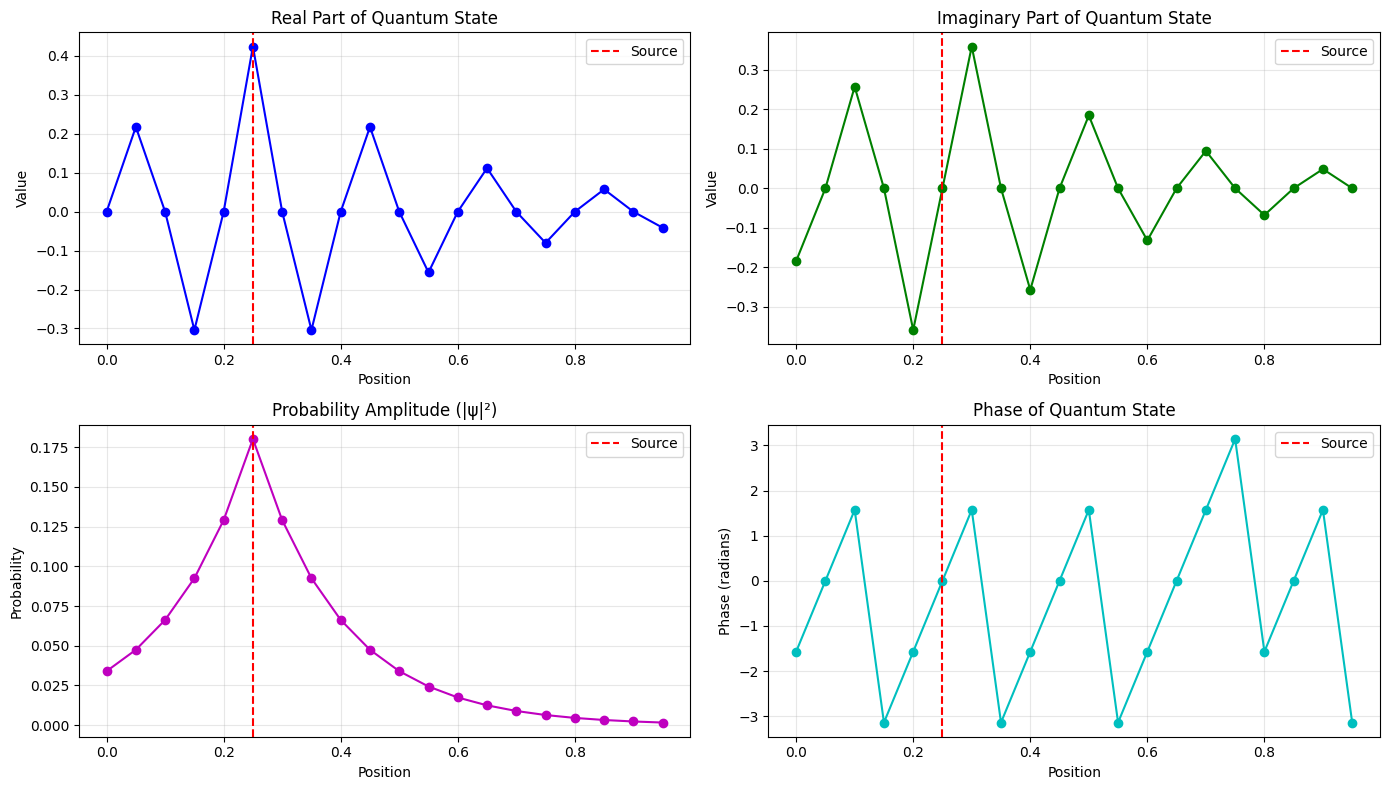

Wave number parameter k = 5
Corresponding wavelength = 0.2000
Array length L = 1.0
Number of wavelengths in array = 5.00


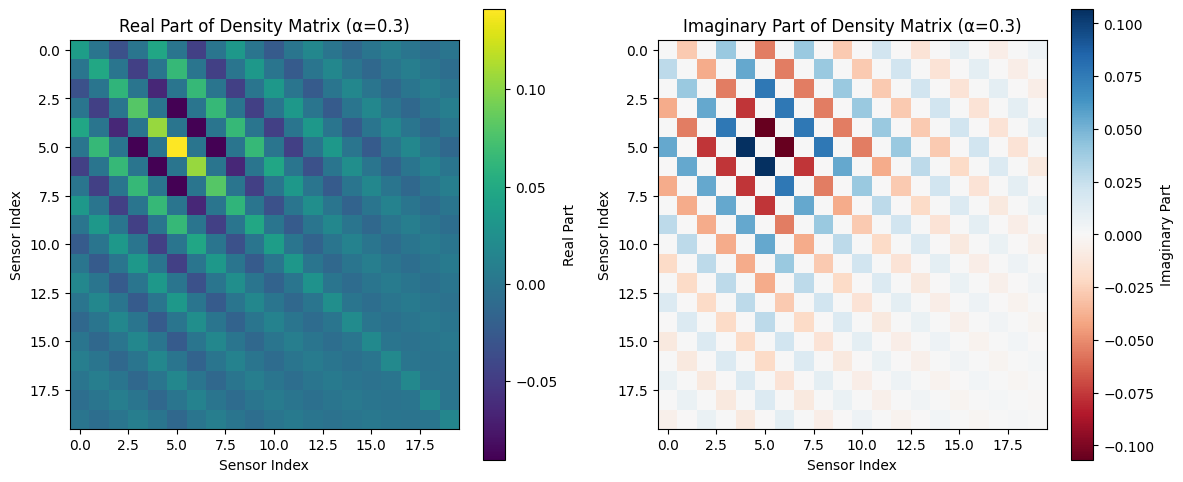

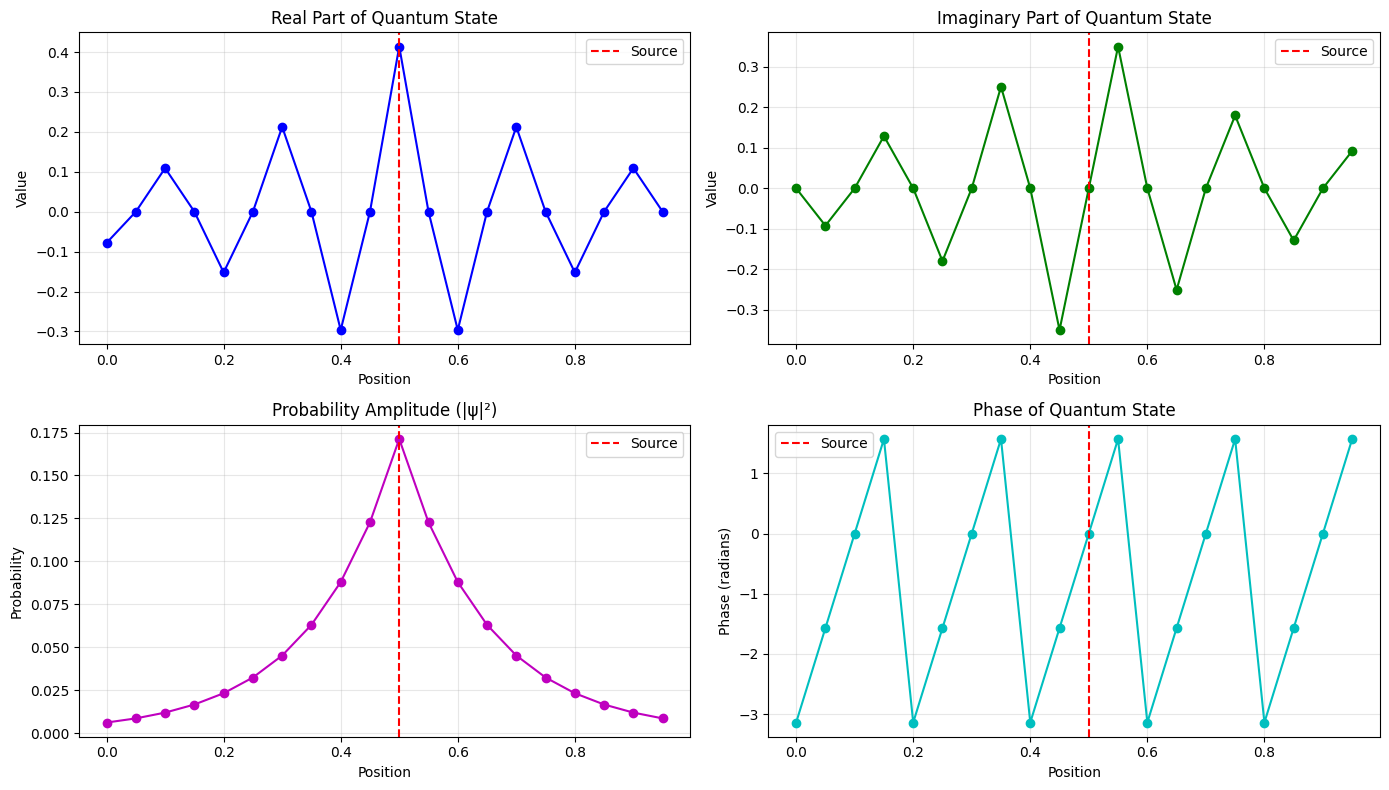

Wave number parameter k = 5
Corresponding wavelength = 0.2000
Array length L = 1.0
Number of wavelengths in array = 5.00


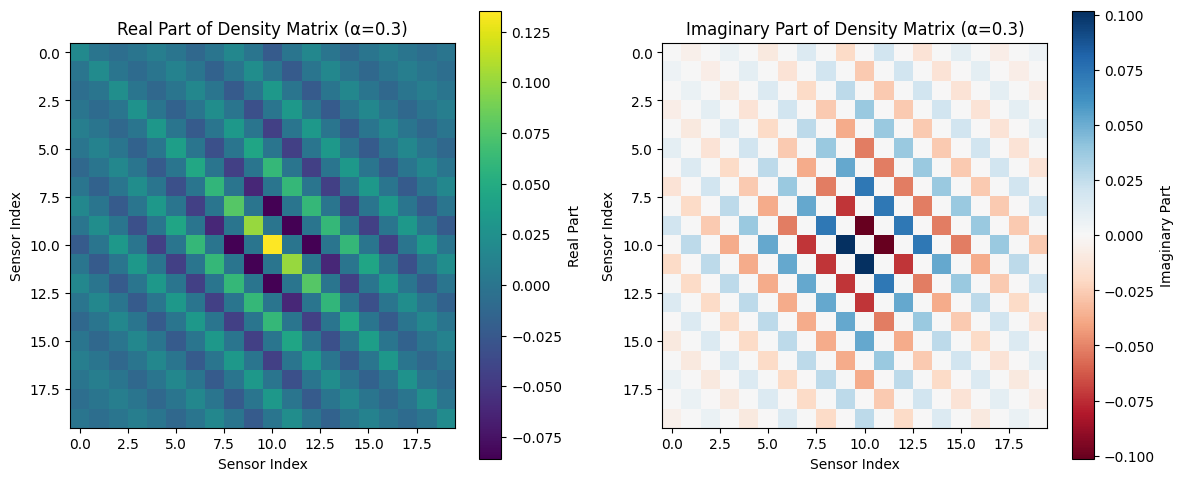

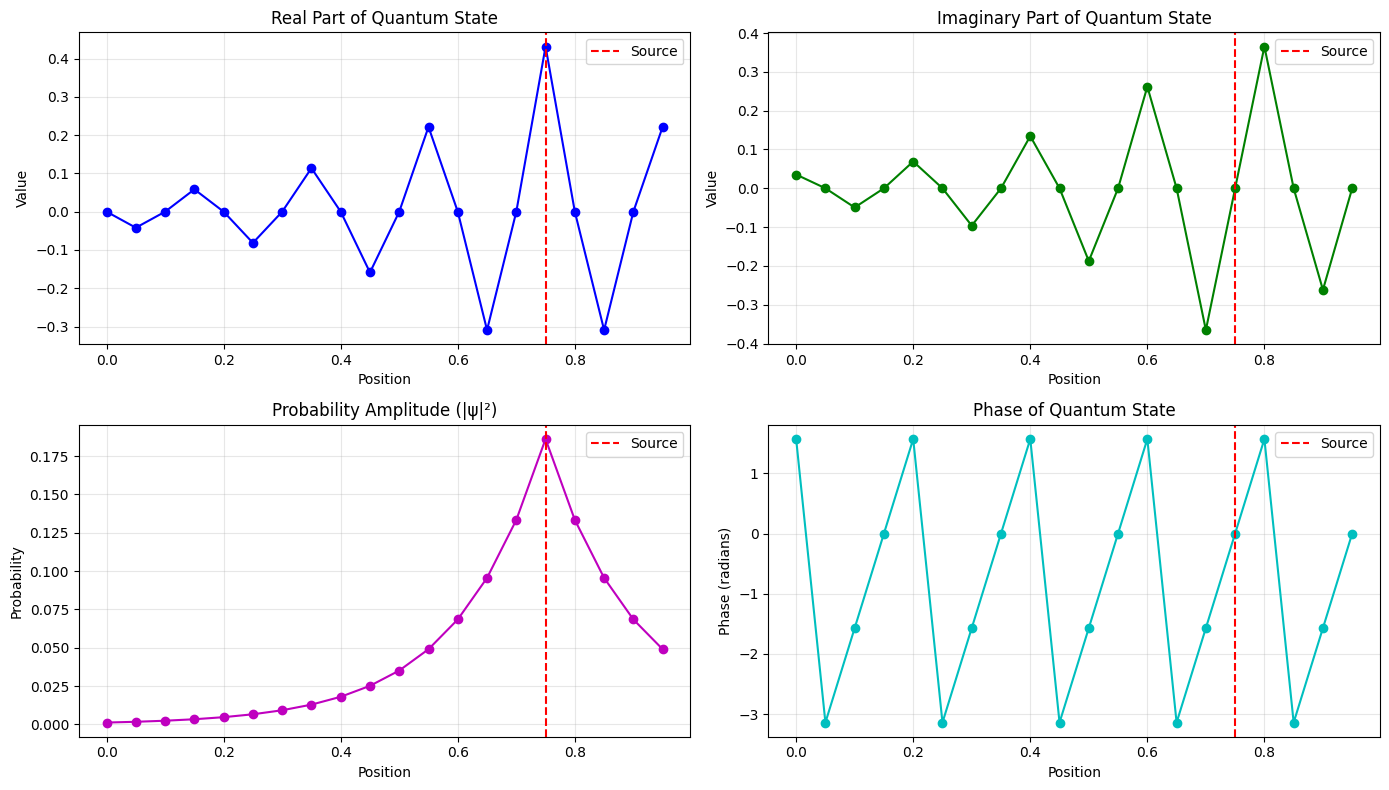

Wave number parameter k = 5
Corresponding wavelength = 0.2000
Array length L = 1.0
Number of wavelengths in array = 5.00


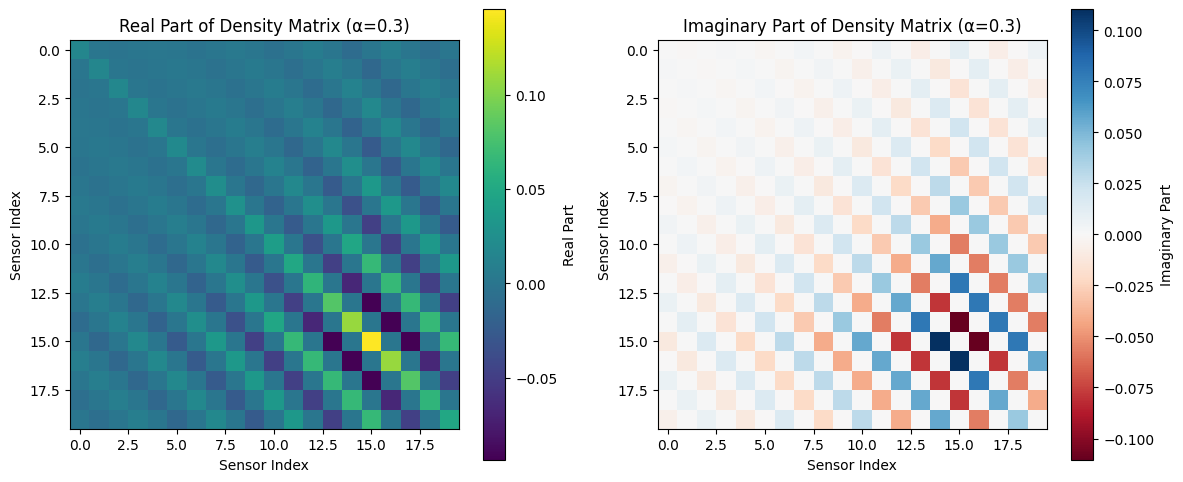

Visualization complete


In [ ]:
# State visualization to verify phase encoding (sanity check)
if __name__ == "__main__":

    print("Running state visualization for sanity check")
    run_state_visualization()

Run 1/3
  Testing with 0.1 average photons
  Testing with 0.2 average photons
  Testing with 0.5 average photons
  Testing with 0.7 average photons
  Testing with 1 average photons
  Testing with 5 average photons
  Testing with 10 average photons
  Testing with 15 average photons
  Testing with 20 average photons
  Testing with 25 average photons
  Testing with 50 average photons
  Testing with 100 average photons
  Testing with 200 average photons
Run 2/3
  Testing with 0.1 average photons
  Testing with 0.2 average photons
  Testing with 0.5 average photons
  Testing with 0.7 average photons
  Testing with 1 average photons
  Testing with 5 average photons
  Testing with 10 average photons
  Testing with 15 average photons
  Testing with 20 average photons
  Testing with 25 average photons
  Testing with 50 average photons
  Testing with 100 average photons
  Testing with 200 average photons
Run 3/3
  Testing with 0.1 average photons
  Testing with 0.2 average photons
  Testing with

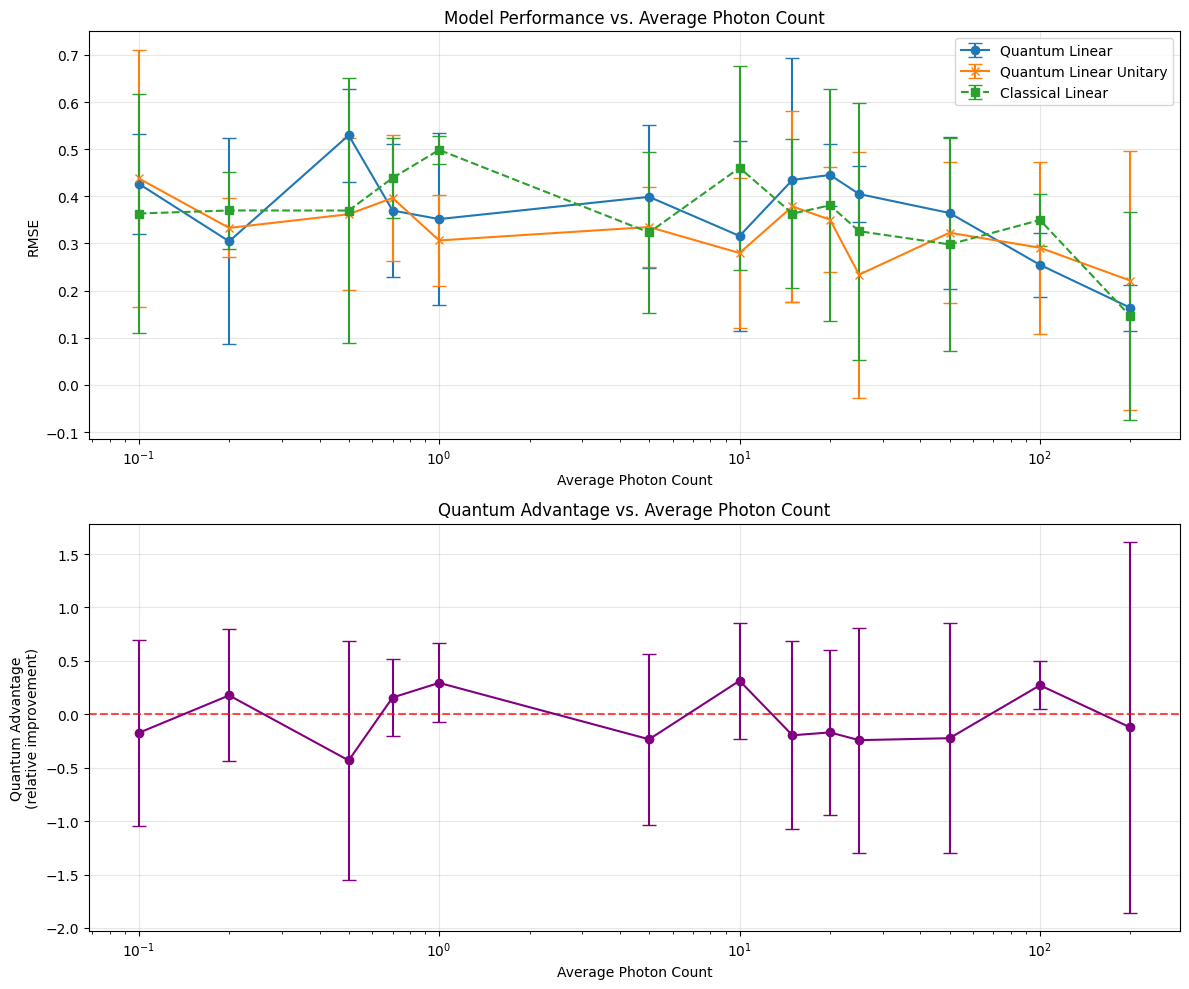


Summary of Low Photon Number Analysis:

RMSE for different photon counts (with 95% CI):

Average photon count: 0.1
  - Quantum Linear RMSE: 0.426713 ± 0.106267
  - Quantum Linear Unitary RMSE: 0.438002 ± 0.272668
  - Classical Linear RMSE: 0.363491 ± 0.254015
  - Quantum Advantage: -17.39% ± 87.09%

Average photon count: 0.2
  - Quantum Linear RMSE: 0.304459 ± 0.218437
  - Quantum Linear Unitary RMSE: 0.332987 ± 0.062633
  - Classical Linear RMSE: 0.369965 ± 0.081256
  - Quantum Advantage: 17.71% ± 61.75%

Average photon count: 0.5
  - Quantum Linear RMSE: 0.529473 ± 0.098773
  - Quantum Linear Unitary RMSE: 0.361994 ± 0.161244
  - Classical Linear RMSE: 0.369789 ± 0.281143
  - Quantum Advantage: -43.18% ± 112.09%

Average photon count: 0.7
  - Quantum Linear RMSE: 0.369828 ± 0.141786
  - Quantum Linear Unitary RMSE: 0.396399 ± 0.134178
  - Classical Linear RMSE: 0.438851 ± 0.084027
  - Quantum Advantage: 15.73% ± 36.11%

Average photon count: 1
  - Quantum Linear RMSE: 0.351683 ± 0.1

In [ ]:
# Quantum shot noise for low photon count regimes
if __name__ == "__main__":
    low_photon_results = run_low_photon_analysis(
        n_runs=n_runs,
        photon_counts=photon_counts
    )

Running basic experiment comparing linear and quadratic models

Results with 95% Confidence Intervals:
  - Quantum Linear Model RMSE (95% CI): 0.031575 ± 0.035799
  - Quantum Quadratic Model RMSE (95% CI): 0.227599 ± 0.392566
  - Classical Linear Model RMSE (95% CI): 0.004977 ± 0.002808
  - Classical Quadratic Model RMSE (95% CI): 0.004616 ± 0.002452

Statistical Tests (p-values):
  - Quantum Linear vs. Quantum Quadratic: 0.275402
  - Classical Linear vs. Classical Quadratic: 0.829139
  - Quantum Linear vs. Classical Linear: 0.111102
  - Quantum Quadratic vs. Classical Quadratic: 0.215113

Statistical Significance (α = 0.05):
  - q_linear_vs_q_quad: Not significant (p = 0.275402)
  - c_linear_vs_c_quad: Not significant (p = 0.829139)
  - q_linear_vs_c_linear: Not significant (p = 0.111102)
  - q_quad_vs_c_quad: Not significant (p = 0.215113)


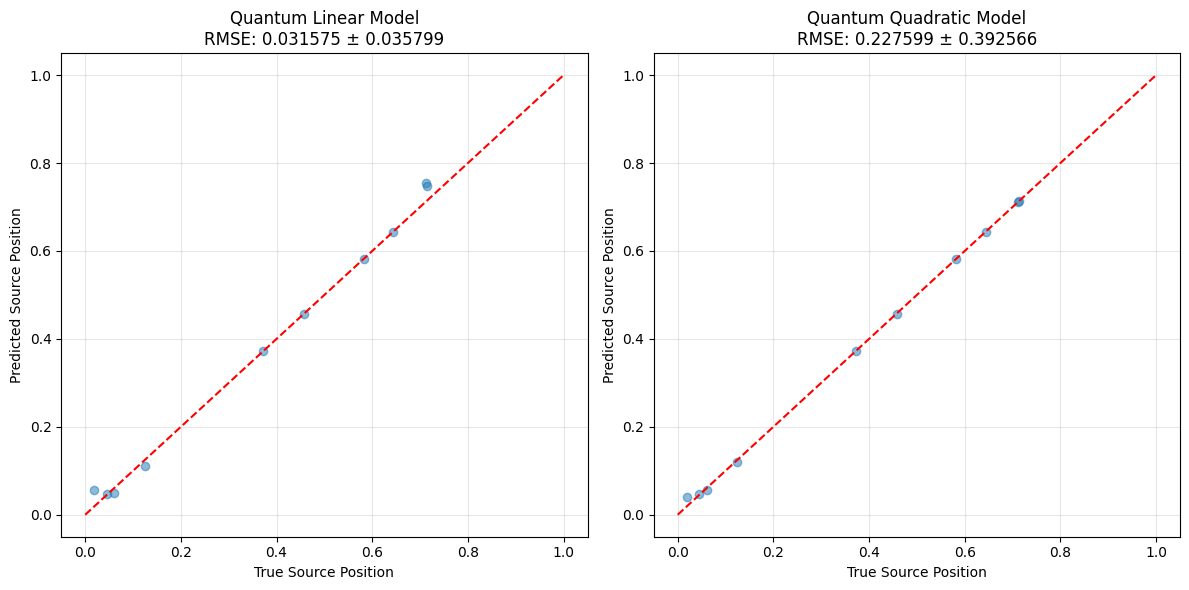


Running experiments with finite sampling and unitary projection
Running basic experiment with finite sampling effects
Run 1/10...
Run 2/10...
Run 3/10...
Run 4/10...
Run 5/10...
Run 6/10...
Run 7/10...
Run 8/10...
Run 9/10...
Run 10/10...

Results with 95% Confidence Intervals (with finite sampling effects):
  - Quantum Linear Model RMSE (95% CI): 0.057958 ± 0.004793
  - Quantum Linear Unitary-Projected RMSE (95% CI): 0.209083 ± 0.048203
  - Quantum Quadratic Model RMSE (95% CI): 0.071493 ± 0.008385
  - Classical Linear Model RMSE (95% CI): 0.061272 ± 0.011542
  - Classical Quadratic Model RMSE (95% CI): 0.083030 ± 0.014630

Statistical Tests (p-values):
  - Quantum Linear vs. Quantum Quadratic: 0.005298
  - Quantum Linear vs. Quantum Linear Unitary: 0.000001
  - Quantum Linear vs. Classical Linear: 0.555985

Statistical Significance (α = 0.05):
  - q_linear_vs_q_quad: Significant (p = 0.005298)
  - q_linear_vs_c_linear: Not significant (p = 0.555985)
  - q_linear_vs_q_unitary: Signif

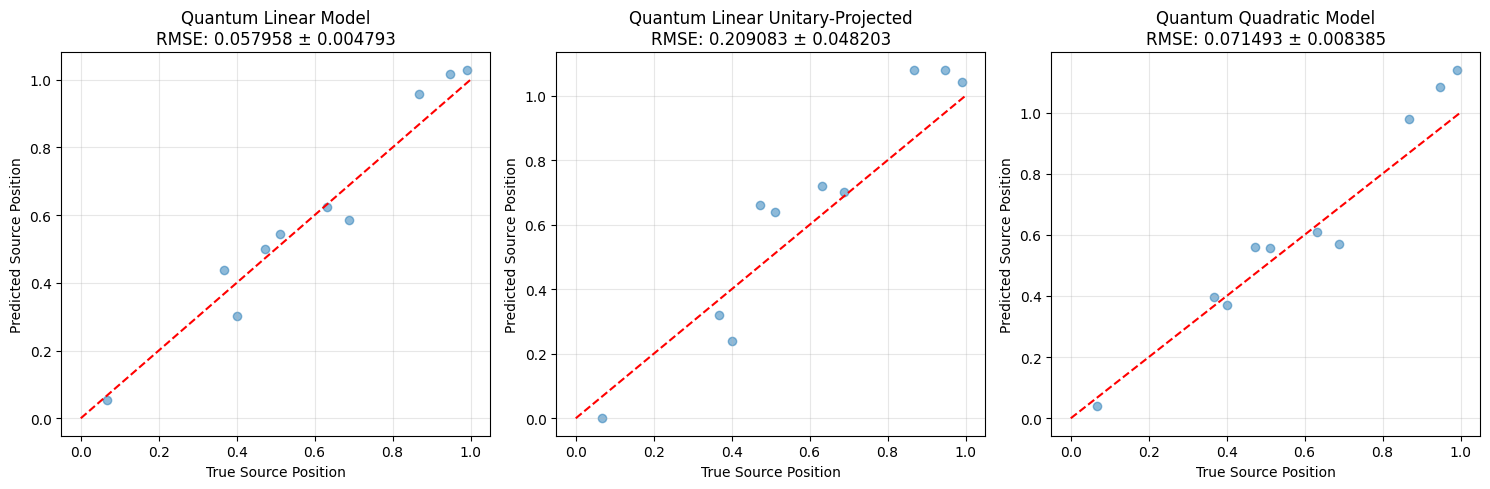


======= SUMMARY OF KEY FINDINGS =======
1. Basic Experiment Results:
   - Best model: Classical Quadratic
   - Quantum advantage (linear): No
   - Quantum advantage (quadratic): No

2. Finite Sampling and Unitary Projection:
   - Linear model RMSE: 0.057958
   - Unitary-projected RMSE: 0.209083
   - Performance change: 260.75%
   - Statistically significant: Yes


In [ ]:
# Basic Experiments
if __name__ == "__main__":

    # Run basic experiment with confidence intervals and statistical tests
    basic_results = run_basic_experiment(n_runs=n_basic_runs, perform_tests=True)

    # Run experiment with finite sampling and unitary projection
    print("\nRunning experiments with finite sampling and unitary projection")
    sampling_results = run_basic_experiment_with_sampling(
        n_runs=n_basic_runs,
        perform_tests=True,
        n_measurements=n_measurements,  # Number of measurements for density matrix reconstruction
        n_pred_samples=n_pred_samples   # Number of samples for prediction
    )

    # Summary of key findings
    print("\n======= SUMMARY OF KEY FINDINGS =======")
    print("1. Basic Experiment Results:")
    print(f"   - Best model: {'Quantum' if basic_results['rmse_quad_q'] < basic_results['rmse_quad_c'] else 'Classical'} Quadratic")
    print(f"   - Quantum advantage (linear): {'Yes' if basic_results['rmse_linear_q'] < basic_results['rmse_linear_c'] else 'No'}")
    print(f"   - Quantum advantage (quadratic): {'Yes' if basic_results['rmse_quad_q'] < basic_results['rmse_quad_c'] else 'No'}")

    print("\n2. Finite Sampling and Unitary Projection:")
    print(f"   - Linear model RMSE: {sampling_results['rmse_linear_q']:.6f}")
    print(f"   - Unitary-projected RMSE: {sampling_results['rmse_lin_q_unitary']:.6f}")
    print(f"   - Performance change: {((sampling_results['rmse_lin_q_unitary'] - sampling_results['rmse_linear_q'])/sampling_results['rmse_linear_q']*100):.2f}%")
    print(f"   - Statistically significant: {'Yes' if sampling_results['p_values']['q_linear_vs_q_unitary'] < 0.05 else 'No'}")

Analyzing impact of noise levels on both ideal and realistic models...
Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


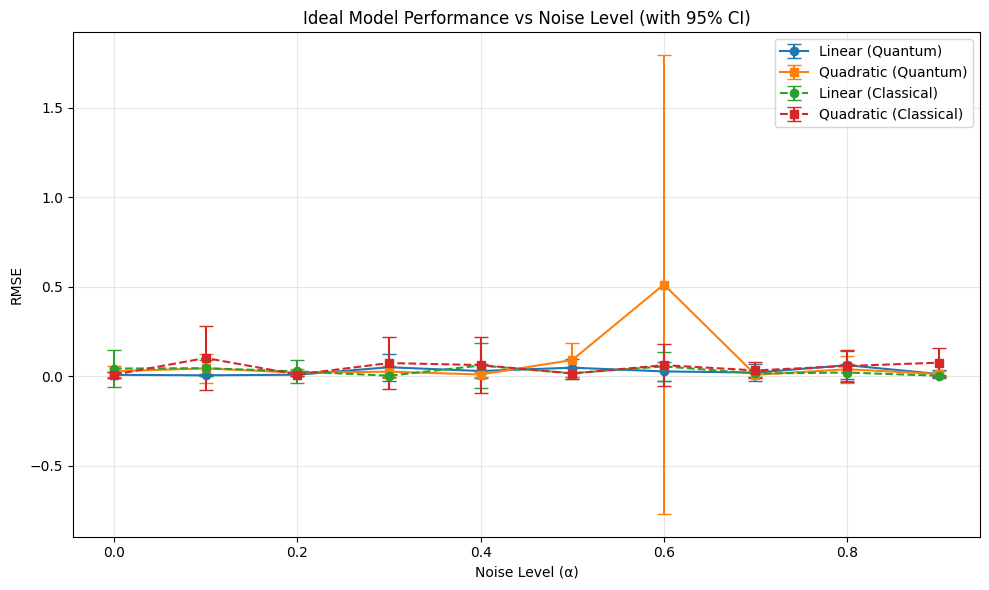

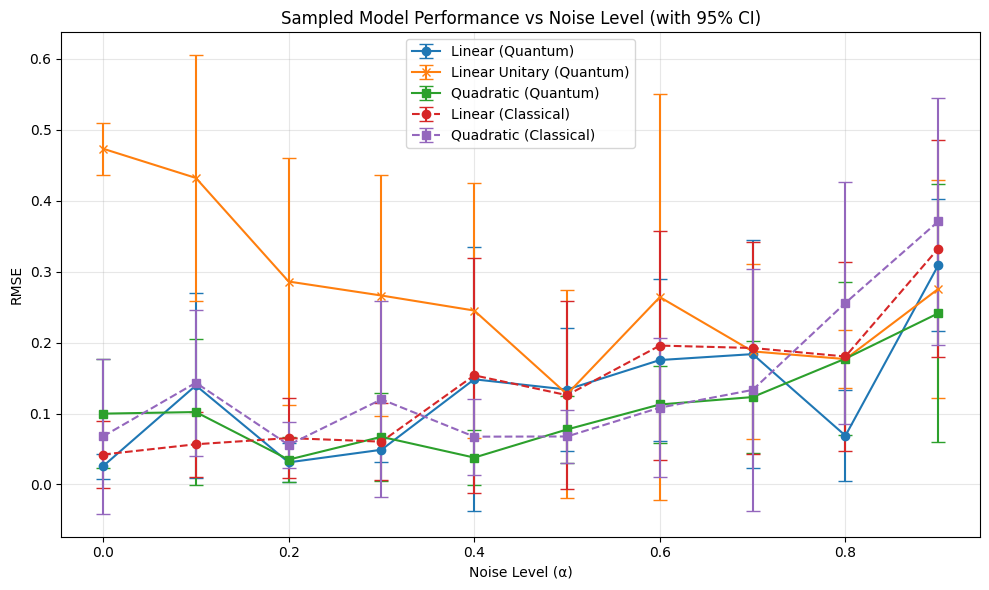


Summary for key noise levels - IDEAL MODELS (with 95% CI):

At noise level α = 0.0:
  - Quantum Degree1 RMSE (95% CI): 0.007707 ± 0.017673
  - Quantum Degree2 RMSE (95% CI): 0.027869 ± 0.031767
  - Classical Degree1 RMSE (95% CI): 0.042932 ± 0.103420
  - Classical Degree2 RMSE (95% CI): 0.008546 ± 0.015790

At noise level α = 0.3:
  - Quantum Degree1 RMSE (95% CI): 0.050038 ± 0.074705
  - Quantum Degree2 RMSE (95% CI): 0.025330 ± 0.032774
  - Classical Degree1 RMSE (95% CI): 0.002640 ± 0.004391
  - Classical Degree2 RMSE (95% CI): 0.073531 ± 0.144349

At noise level α = 0.6:
  - Quantum Degree1 RMSE (95% CI): 0.026764 ± 0.054662
  - Quantum Degree2 RMSE (95% CI): 0.512083 ± 1.280613
  - Classical Degree1 RMSE (95% CI): 0.054942 ± 0.079273
  - Classical Degree2 RMSE (95% CI): 0.061650 ± 0.116894

At noise level α = 0.9:
  - Quantum Degree1 RMSE (95% CI): 0.012264 ± 0.024463
  - Quantum Degree2 RMSE (95% CI): 0.012126 ± 0.017738
  - Classical Degree1 RMSE (95% CI): 0.002470 ± 0.003864
 

In [ ]:
# Noise impact analysis with confidence intervals
if __name__ == "__main__":

    noise_results = run_noise_analysis(n_runs=n_noise_runs)

===== Memory-Efficient Quantum Copies Analysis =====

Estimated memory requirements for naive tensor product approach:
1 copies: 800 features, 312.50 KB for 50 samples
2 copies: 320000 features, 122.07 MB for 50 samples
4 copies: 51200000000 features, 18.63 TB for 50 samples
8 copies: 1310720000000000000000 features, 476837158203.12 TB for 50 samples
Running memory-efficient analysis for [1, 2, 4, 8] copies

Processing 1 copies...
  Run 1/3
  Using symmetrized features for 1 copies
  RMSE: 0.008028 (Time: 0.01s)
  Run 2/3
  Using symmetrized features for 1 copies
  RMSE: 0.000356 (Time: 0.01s)
  Run 3/3
  Using symmetrized features for 1 copies
  RMSE: 0.014479 (Time: 0.01s)
  Average RMSE: 0.007621 ± 0.017563 (95% CI)
  Average Time: 0.01s

Processing 2 copies...
  Run 1/3
  Using symmetrized features for 2 copies
  RMSE: 0.000735 (Time: 0.03s)
  Run 2/3
  Using symmetrized features for 2 copies
  RMSE: 0.000658 (Time: 0.04s)
  Run 3/3
  Using symmetrized features for 2 copies
  RMSE:

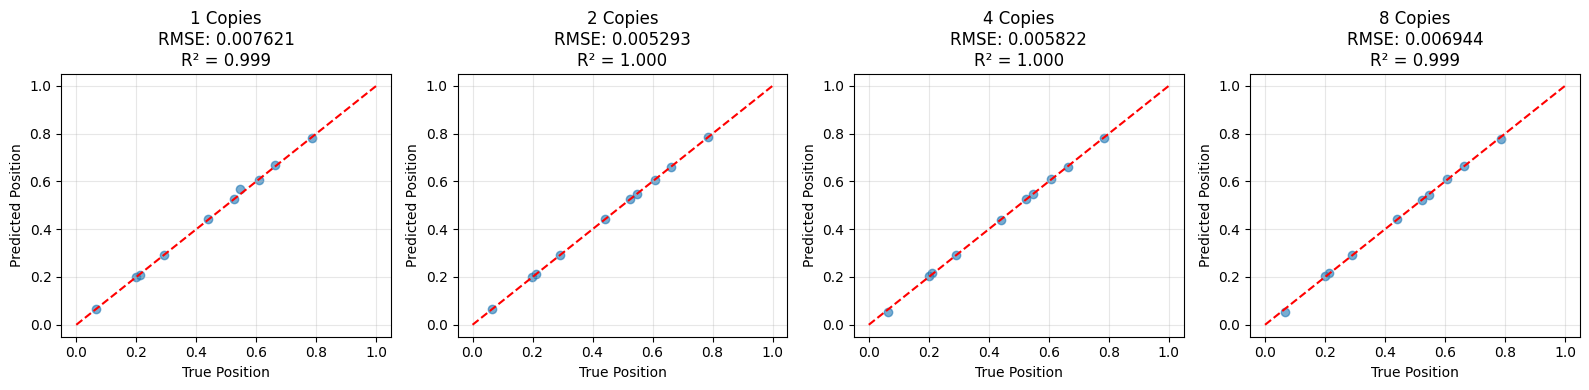


Performance Summary:
   Copies       RMSE       95% CI     Time (s)  
------------------------------------------------
     1      0.007621±0.0175630.01s
     2      0.005293±0.0197770.04s
     4      0.005822±0.0032540.02s
     8      0.006944±0.0032980.02s
------------------------------------------------
Extrapolated Values:
     9      0.006162
     10     0.006145
     11     0.006130
     12     0.006116
     13     0.006103
     14     0.006091
     15     0.006080
     16     0.006069


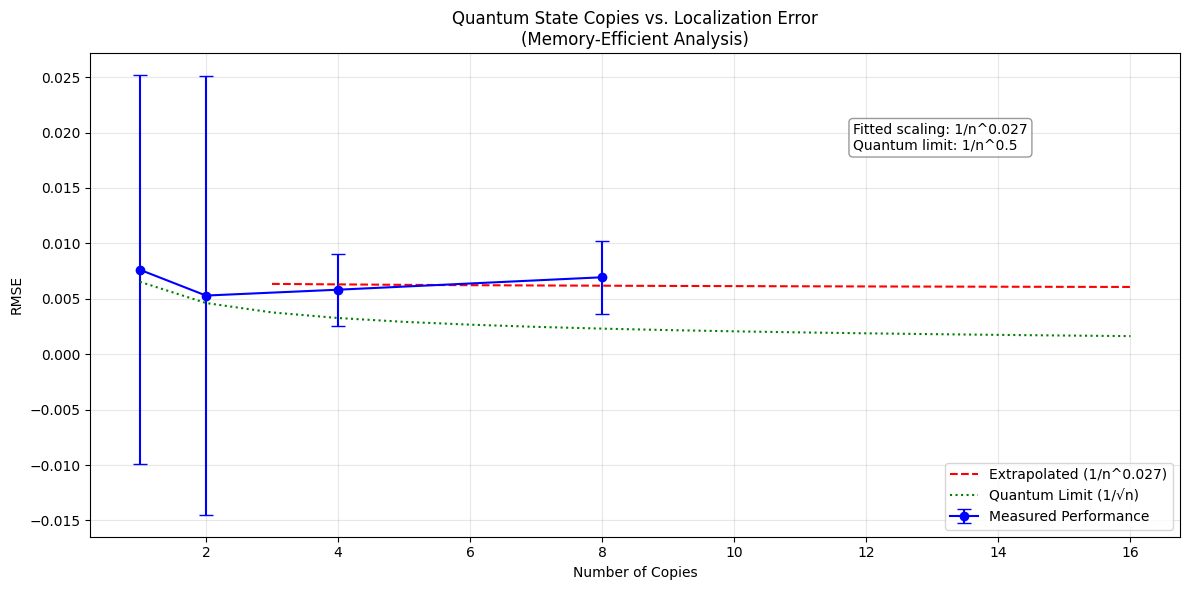

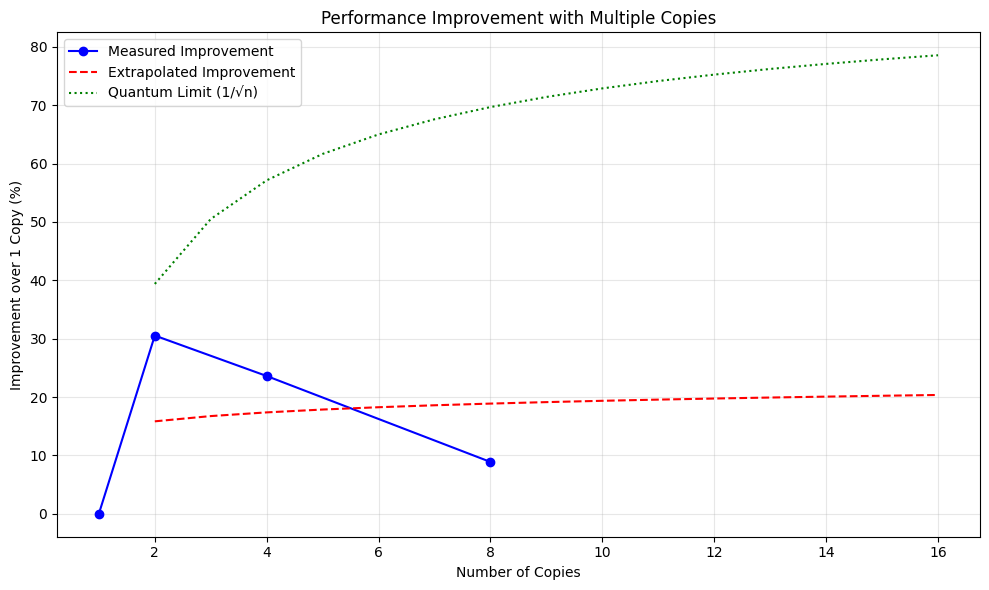

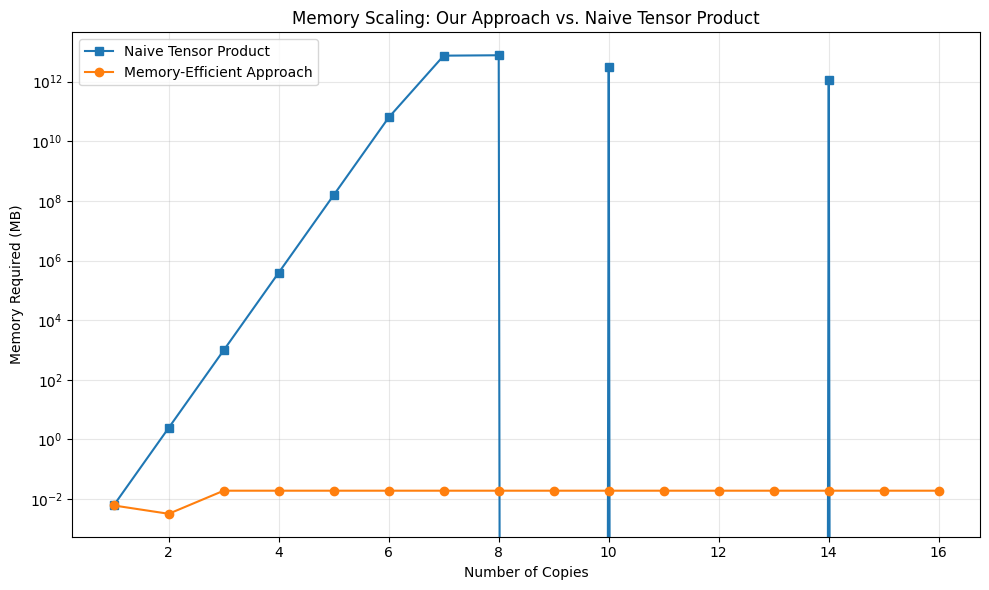


===== Theoretical Interpretation =====
Fitted scaling parameter: 0.0265
Theoretical quantum limit (Heisenberg): 0.5000
Our measurement suggests sub-Heisenberg scaling

Memory savings: 2.62e+19x reduction
Our approach enables quantum advantages without exponential memory growth

===== Conclusions =====
Memory requirements were reduced by factors of 3e+19x for high copy numbers
Performance scaling was measured at approximately 1/n^0.027
The quantum theoretical limit is 1/n^0.5 (Heisenberg limit)
With 16 copies, we predict RMSE of 0.006069
   (compared to 0.007621 with 1 copy)
This represents a 20.4% improvement in localization precision


In [ ]:
# Quantum Copies Analysis (memory-efficient)

if __name__ == "__main__":
    np.random.seed(42)

    print("===== Memory-Efficient Quantum Copies Analysis =====")

    # Compare memory requirements for naive tensor product
    print("\nEstimated memory requirements for naive tensor product approach:")
    for n_copies in n_copies_list:
        feature_dim = 2 * (d ** n_copies) ** 2  # Real and imaginary parts
        memory_bytes = feature_dim * 8 * num_samples  # 8 bytes per float64 * samples

        # Convert to appropriate unit
        if memory_bytes < 1024**2:
            memory_size = memory_bytes / 1024
            unit = "KB"
        elif memory_bytes < 1024**3:
            memory_size = memory_bytes / (1024**2)
            unit = "MB"
        elif memory_bytes < 1024**4:
            memory_size = memory_bytes / (1024**3)
            unit = "GB"
        else:
            memory_size = memory_bytes / (1024**4)
            unit = "TB"

        print(f"{n_copies} copies: {feature_dim} features, {memory_size:.2f} {unit} for {num_samples} samples")

    # Run the memory-efficient analysis
    results, n_range, rmse_extrap, fitted_slope = analyze_copies_memory_efficient(
        n_copies_list, max_extrapolation, num_samples, alpha, n_runs)

    # Print theoretical interpretation
    print("\n===== Theoretical Interpretation =====")
    print(f"Fitted scaling parameter: {-fitted_slope:.4f}")
    print(f"Theoretical quantum limit (Heisenberg): 0.5000")
    print(f"Our measurement suggests {'Heisenberg' if abs(fitted_slope - 0.5) < 0.1 else 'sub-Heisenberg'} scaling")

    # Print overall memory savings
    max_copy = max(n_copies_list)
    naive_mem = 2 * (d ** (2*max_copy)) * 8 * num_samples  # bytes
    if max_copy <= 2:
        if max_copy == 1:
            our_mem = 2 * d**2 * 8 * num_samples
        else:  # max_copy == 2
            sym_dim = d * (d + 1) // 2
            our_mem = 2 * sym_dim * 8 * num_samples
    else:
        our_mem = num_samples**2 * 8  # Kernel matrix size

    reduction = naive_mem / our_mem
    print(f"\nMemory savings: {reduction:.2e}x reduction")
    print(f"Our approach enables quantum advantages without exponential memory growth")

    # Final conclusions
    print("\n===== Conclusions =====")
    print(f"Memory requirements were reduced by factors of {reduction:.0e}x for high copy numbers")
    print(f"Performance scaling was measured at approximately 1/n^{-fitted_slope:.3f}")
    print(f"The quantum theoretical limit is 1/n^0.5 (Heisenberg limit)")

    # Get RMSE values for 1 and max extrapolation copies
    rmse_1copy = results['rmse_mean'][0]
    rmse_max = rmse_extrap[max_extrapolation-1]
    improvement_percent = ((rmse_1copy - rmse_max) / rmse_1copy * 100)

    print(f"With {max_extrapolation} copies, we predict RMSE of {rmse_max:.6f}")
    print(f"   (compared to {rmse_1copy:.6f} with 1 copy)")
    print(f"This represents a {improvement_percent:.1f}% improvement in localization precision")